# Speed Line Modeling using Surrogates

## Overview

In this notebook we perform experiments on the provided 3 Speed Line Datasets of the Marine Compressor. We make use of the following optimizers:
- *Differential Evolution*
- *Dual Annealing*
- *Direct*
- *Basin Hopping*

The code that follows, automates the process of execution on each possible combination of optimizer and dataset. 

**Note**: WIP - Testing with Different Error Bounds

### Import Dependencies 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from operator import itemgetter
from typing import Optional, Dict
from scipy.optimize import differential_evolution, dual_annealing, direct

from spotpython.spot import spot
from spotpython.fun.objectivefunctions import Analytical
from spotpython.utils.init import fun_control_init, surrogate_control_init, design_control_init

from spotoptim.data.speedline_data import SpeedlineData
from spotoptim.preprocessing.speedlines import preprocess
from spotoptim.fit.single_fit import update_model_coeff, residual_func, calculate_bounds
from spotoptim.plot.speedplot import plot_speedline_fit, get_limits
from spotoptim.math.eval import evaluate_optimization_results
from spotoptim.models.llamas import llamas_m, llamas_pi


Seed set to 123


## Helper Functions

In [ ]:
def get_overall_rmse(sl_data, data_dict_name, res):
    x_values = {key: result["x"] for key, result in res.items()}

    measurements_preprocessed = sl_data.datadicts[data_dict_name]["measurements_preprocessed"]

    all_m_V = []
    all_m_V_hat = []
    all_Pi_tot_V = []
    all_Pi_tot_V_hat = []

    # Perform fit specialized for superelliptical datapoints on each speedline
    for speedline, group in measurements_preprocessed.groupby("Speedclass [m/s]"):
        m_V = np.array(group["m_V [kg/s]"])
        Pi_tot_V = np.array(group["Pi_tot_V [-]"])

        # Iterate over each beta value in the dictionary and compute errors
        if speedline in x_values:
            beta = x_values[speedline]
            Pi_tot_V_hat = llamas_pi(beta, m_V)
            m_V_hat = llamas_m(beta, Pi_tot_V)

            # Collect all values for overall RMSE calculation
            all_m_V.extend(m_V)
            all_m_V_hat.extend(m_V_hat)
            all_Pi_tot_V.extend(Pi_tot_V)
            all_Pi_tot_V_hat.extend(Pi_tot_V_hat)

    # Convert lists to NumPy arrays
    all_m_V = np.array(all_m_V)
    all_m_V_hat = np.array(all_m_V_hat)
    all_Pi_tot_V = np.array(all_Pi_tot_V)
    all_Pi_tot_V_hat = np.array(all_Pi_tot_V_hat)

    # Compute RMSE
    rmse_m_V = np.sqrt(np.mean((all_m_V - all_m_V_hat) ** 2))
    rmse_Pi_tot_V = np.sqrt(np.mean((all_Pi_tot_V - all_Pi_tot_V_hat) ** 2))

    # Normalize using the maximum of the predicted values
    norm_m_V = rmse_m_V / np.max(all_m_V_hat)
    norm_Pi_tot_V = rmse_Pi_tot_V / np.max(all_Pi_tot_V_hat)

    return norm_Pi_tot_V, norm_m_V

In [2]:
class ResidualFunction(Analytical):
    def fun_user_function(self, X: np.ndarray, fun_control: Optional[Dict] = None) -> np.ndarray:
        """
        Interface to the residual function from spotoptim (`residual_func`), which is used to fit the speedline data.
        
        Args:
            X (np.ndarray): Input data as a 2D array.
            fun_control (Optional[Dict]): Control parameters for the function.
        
        Returns:
            np.ndarray: Computed values.
        
        Examples:
            >>> import numpy as np
                user_fun = ResidualFunction()
                X = np.array([[1., 2., 3., 4., 5.], [.1, .2, .3, .4, .5]])
                results = user_fun.fun_user_function(X, fun_control={"m_V": np.array([1., 2., 3.]), "Pi_tot_V": np.array([4., 5., 6.])})
                print(results)
        """
        m_V = fun_control["m_V"]
        Pi_tot_V = fun_control["Pi_tot_V"]
        X = self._prepare_input_data(X, fun_control)
        n = X.shape[0]
        y = np.zeros(n)
        for i in range(n):
            beta = X[i, :]
            y[i] = residual_func(beta, m_V, Pi_tot_V)        
        return y

In [ ]:
def spot_fit(
    sl_data,
    data_dict_name,
    x0 = None,
    optimizer = differential_evolution,
    a_m_zsl = 0.75,
    b_m_zsl = 1.25,
    a_m_chl = 0.75,
    b_m_chl = 1.25,
    a_pi_chl = 0.75,
    b_pi_chl = 1.25,
    a_pi_zsl = 0.75,
    b_pi_zsl = 1.25,
    a_cur = 2,
    b_cur = 15,
    TENSORBOARD_CLEAN = False,
    tensorboard_log = False,
    verbosity = 0,
    fun_evals = 40,
    init_size = 35,
    max_time = 10,
    PREFIX = "USER",
    plot_graphs = False,
) -> dict:
    measurements_preprocessed = sl_data.datadicts[data_dict_name]["measurements_preprocessed"]

    optimization_results = {}

    # Group the data according to the config and then run spot_fit on it
    for speedline, group in measurements_preprocessed.groupby("Speedclass [m/s]"):
        m_V = np.array(group["m_V [kg/s]"])
        Pi_tot_V = np.array(group["Pi_tot_V [-]"])
        
        bounds = calculate_bounds(
            m_V, 
            Pi_tot_V, 
            a_m_zsl = a_m_zsl, 
            b_m_zsl = b_m_zsl, 
            a_m_chl = a_m_chl, 
            b_m_chl = b_m_chl, 
            a_pi_chl = a_pi_chl, 
            b_pi_chl = b_pi_chl, 
            a_pi_zsl = a_pi_zsl, 
            b_pi_zsl = b_pi_zsl, 
            a_cur = a_cur, 
            b_cur = b_cur
        )
              
        user_fun = ResidualFunction().fun_user_function
        fun_control = fun_control_init(
              PREFIX = PREFIX,              
              lower = np.array([bounds[i][0] for i in range(len(bounds))]),
              upper = np.array([bounds[i][1] for i in range(len(bounds))]),
              var_name = ["zsl", "chl", "pi_chl", "pi_zsl", "cur"],
              TENSORBOARD_CLEAN = TENSORBOARD_CLEAN,
              tensorboard_log = tensorboard_log,
              verbosity = verbosity,
              fun_evals = fun_evals,
              max_time = max_time
              )
        
        fun_control["m_V"] = m_V
        fun_control["Pi_tot_V"] = Pi_tot_V

        design_control = design_control_init(init_size = init_size)
        surrogate_control = surrogate_control_init(model_optimizer = optimizer, noise = True)
        
        spot_user = spot.Spot(fun = user_fun,
                              optimizer = optimizer,
                              fun_control = fun_control,
                              design_control = design_control,
                              surrogate_control = surrogate_control)
        result = spot_user.run(X_start = x0)
        
        if plot_graphs:
            spot_user.plot_progress(log_y=True)
            spot_user.plot_important_hyperparameter_contour(max_imp=3)
        
        out = result.print_results(print_screen = True)
        
        beta_0 = out[0][1]
        beta_1 = out[1][1]
        beta_2 = out[2][1]
        beta_3 = out[3][1]
        beta_4 = out[4][1]

        result = {"x": [beta_0, beta_1, beta_2, beta_3, beta_4]}
        optimization_results[speedline] = result

    return optimization_results

`run_spot_fit()` is used for running the `spot_fit` function for each optimization method. It returns the speed line data and the corresponding results in a `dict`.

In [4]:
def run_spot_fit(exp_name, df, optimizer, x0, fun_evals = 40, plot_graphs = True, init_size = 5):
    # Create a data object and store the data in it
    exp_data = {"measurements": df}
    sld = SpeedlineData(exp_name, exp_data)

    # Preprocess the data
    sld = preprocess(sld, 
                     exp_name, 
                     method = "normalize")

    # Run the spot_fit function
    res = spot_fit(sl_data = sld,
                   data_dict_name = exp_name,
                   optimizer = optimizer,
                   x0 = x0,
                   init_size = init_size,
                   fun_evals = fun_evals,
                   plot_graphs = plot_graphs)

    return sld, res

`execute_optimization()` takes the data and optimization pairs along with the required metric and runs a loop. Inside the loop `run_spot_fit()`method is called for each unique case.

In [5]:
def execute_optimization(data_opt_pairs, x0 = None, fun_evals = 40, plot_graphs = True, init_size = 5): 
    test_results = []

    for (exp_data, optimizer) in data_opt_pairs:
        print(f"Using {optimizer.__name__} optimizer on {exp_data} data.\n")

        df = pd.read_csv("data/"+ exp_data + ".csv")
        # print(df.head())

        sld, res = run_spot_fit(exp_data, 
                                df, 
                                optimizer, 
                                x0 = x0,
                                fun_evals = fun_evals,
                                plot_graphs = plot_graphs,
                                init_size = init_size)
        update_model_coeff(sl_data = sld, data_dict_name = exp_data, opt_results = res)
        
        df_err, df_pi, df_m = evaluate_optimization_results(sld, 
                                                            exp_data, 
                                                            res,
                                                            metric_name = "mean_squared_error")
        
        overall_norm_rmse_Pi, overall_norm_rmse_m = get_overall_rmse(sld, exp_data, res)

        test_results.append({"experiment_data": exp_data,
                            "optimizer": optimizer.__name__,
                            "sld": sld,
                            "df_err": df_err,
                            "df_pi": df_pi,
                            "df_m": df_m,
                            "overall_norm_rmse_Pi": overall_norm_rmse_Pi,
                            "overall_norm_rmse_m": overall_norm_rmse_m
                            })
        
    return test_results

## Plotter Functions

`plot_sld()` plots the Speed Line Curves in a **4x3** matrix where each row has the same optimizer and each column has the same dataset.

In [6]:
def plot_sld(test_results, nrows = 4, ncols = 3, figsize = (25, 30)):
    # Sort the test results according to the optimizer
    results = sorted(test_results, key = itemgetter('optimizer'))

    fig, axs = plt.subplots(nrows, ncols, figsize = figsize)
    if nrows * ncols == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    for i, res in enumerate(results):
        xmin, xmax, ymin, ymax = get_limits(res['sld'], res['experiment_data'], s = 0.3)

        plot_speedline_fit(sl_data = res['sld'], 
                        data_dict_name = res['experiment_data'], 
                        axs = axs[i],
                        xmin = xmin, 
                        xmax = xmax, 
                        ymin = ymin, 
                        ymax = ymax,
                        show = False)
        
        axs[i].legend_.remove()
        axs[i].text(0.85, 
                    0.95, 
                    f"Optimizer: {res['optimizer']}", 
                    ha = "center", 
                    va = "center", 
                    fontsize = 12, 
                    weight = "bold", 
                    transform = axs[i].transAxes)  

    handles, labels = axs[0].get_legend_handles_labels()
    # Add a single legend to the entire figure
    fig.legend(handles, labels, loc = 'lower right', bbox_to_anchor = (1, 0), fontsize = 10)
    fig.suptitle('Speed Line Plots', fontsize = 20, weight = 'bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

Evaluation plots are plotted using the `plot_eval()` method.

In [7]:
def plot_eval(exp_sorted_results, value, ylabel, plot_title, nrows = 1, ncols = 3, figsize = (20, 5)):
    # Create a style guide for each optimizer
    colors = {
        'differential_evolution': 'blue',
        'dual_annealing': 'orange',
        'direct': 'red'
        }

    # Create a subplot with 1 row and 3 columns
    fig, axs = plt.subplots(nrows, ncols, figsize = figsize)
    if nrows * ncols == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    ind = 0
    ax = axs[ind]

    for i, result in enumerate(exp_sorted_results):
        # Change the subplot index after every 4 iterations
        ax = axs[i % len(axs)]

        # A dict with dict as values
        df = result['df_err']
        
        configs = list(df.keys())
        values = [entry[value] for entry in df.values()]

        # Provide the linestyles according to an optimizer
        # ax.plot(configs, 
        #         values,
        #         label = result['optimizer'],
        #         **line_styles[result['optimizer']])

        x = np.arange(len(configs))
        width = 0.2

        opt_index = list(colors.keys()).index(result['optimizer'])
        ax.bar(x + width * opt_index, values, width, label = result['optimizer'], color = colors[result['optimizer']])
        
        ax.set_xticks(x)  # Set x-tick positions
        ax.set_xticklabels(configs, rotation = 90, ha = 'center', fontsize = 9)  # Set x-tick labels

        ax.set_xlabel('Speedline', fontsize = 10)
        ax.set_ylabel(ylabel, fontsize = 10)
        ax.set_title(result['experiment_data'])
        ax.grid(visible = True)

    plt.legend(loc="upper left", fontsize = 10)
    fig.suptitle(plot_title, fontsize = 15, weight = 'bold')
    plt.tight_layout(rect = [0, 0, 1, 0.95])

# Without Starting Points

For Least Noisy Dataset.

Params: 
`fun_eval` = 40
`init_size` = 5

### Dual Annealing

In [ ]:
# Define the datasets and optimizers
exp_data_list = [
    # "experiment_4_0.321_0.1_15",
    # "experiment_4_0.321_0.01_15",
    "experiment_4_0.321_0.001_15"
    ]

opt_method_list = [
    # differential_evolution,
    dual_annealing,
    # direct
    ]

# Get the Cartesian product of the lists
data_opt_pairs = product(exp_data_list, opt_method_list)

NameError: name 'dual_annealing' is not defined

Seed set to 123


Using dual_annealing optimizer on experiment_4_0.321_0.001_15 data.

spotpython tuning: 0.09924998622830286 [##--------] 15.00% 
spotpython tuning: 0.09096981095452449 [##--------] 17.50% 
spotpython tuning: 0.09096981095452449 [##--------] 20.00% 
spotpython tuning: 0.09096981095452449 [##--------] 22.50% 
spotpython tuning: 0.09096981095452449 [##--------] 25.00% 
spotpython tuning: 0.09096981095452449 [###-------] 27.50% 
spotpython tuning: 0.09096981095452449 [###-------] 30.00% 
spotpython tuning: 0.09096981095452449 [###-------] 32.50% 
spotpython tuning: 0.09096981095452449 [####------] 35.00% 
spotpython tuning: 0.09096981095452449 [####------] 37.50% 
spotpython tuning: 0.09096981095452449 [####------] 40.00% 
spotpython tuning: 0.09096981095452449 [####------] 42.50% 
spotpython tuning: 0.09096981095452449 [####------] 45.00% 
spotpython tuning: 0.08947026745095452 [#####-----] 47.50% 
spotpython tuning: 0.08947026745095452 [#####-----] 50.00% 
spotpython tuning: 0.0894702674

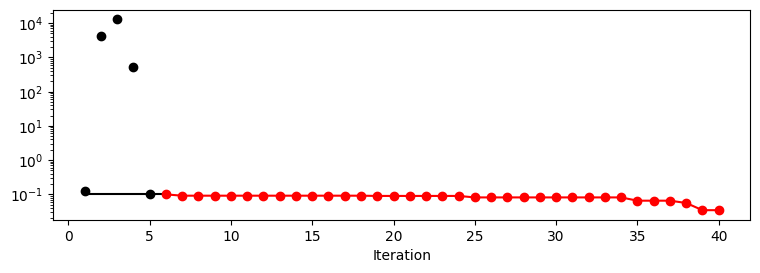

zsl:  0.001
chl:  100.0
pi_chl:  76.87154518840217
pi_zsl:  17.510862679380594
cur:  0.001


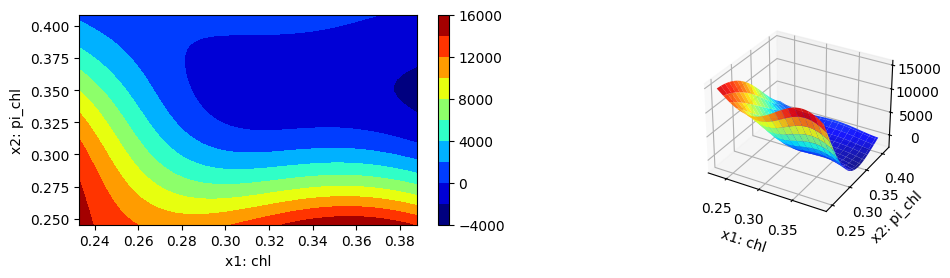

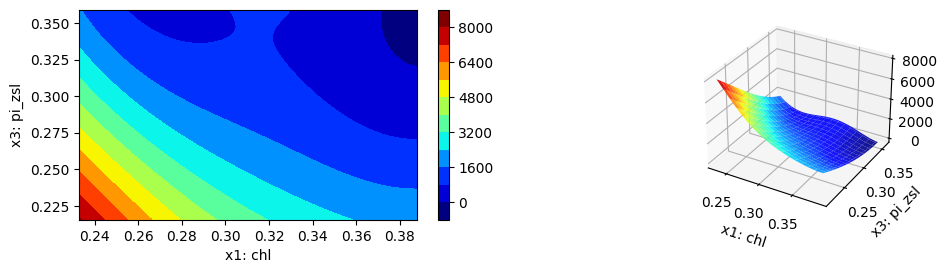

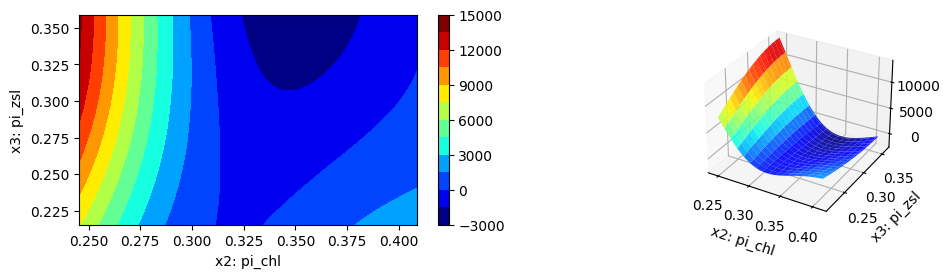

Seed set to 123


min y: 0.03432124265923966
zsl: 0.27799635298358066
chl: 0.3127750479088041
pi_chl: 0.3629265405364856
pi_zsl: 0.26785652438076646
cur: 2.54050136281825
spotpython tuning: 0.10881446849494983 [##--------] 15.00% 
spotpython tuning: 0.10749090363139199 [##--------] 17.50% 
spotpython tuning: 0.10749090363139199 [##--------] 20.00% 
spotpython tuning: 0.10749090363139199 [##--------] 22.50% 
spotpython tuning: 0.08532145647654846 [##--------] 25.00% 
spotpython tuning: 0.08532145647654846 [###-------] 27.50% 
spotpython tuning: 0.08532145647654846 [###-------] 30.00% 
spotpython tuning: 0.08532145647654846 [###-------] 32.50% 
spotpython tuning: 0.08532145647654846 [####------] 35.00% 
spotpython tuning: 0.08532145647654846 [####------] 37.50% 
spotpython tuning: 0.08532145647654846 [####------] 40.00% 
spotpython tuning: 0.08532145647654846 [####------] 42.50% 
spotpython tuning: 0.08532145647654846 [####------] 45.00% 
spotpython tuning: 0.08532145647654846 [#####-----] 47.50% 
spotpyt

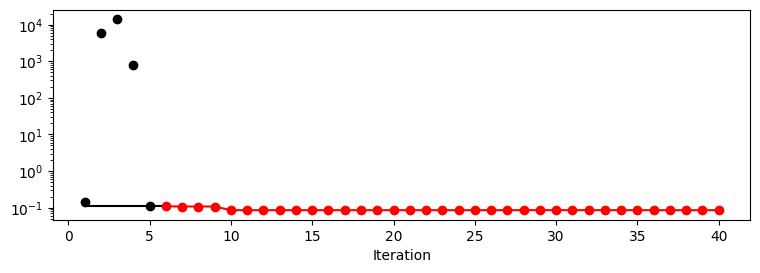

zsl:  11.2164253076364
chl:  100.0
pi_chl:  7.550708303973831
pi_zsl:  55.717280381034904
cur:  0.001


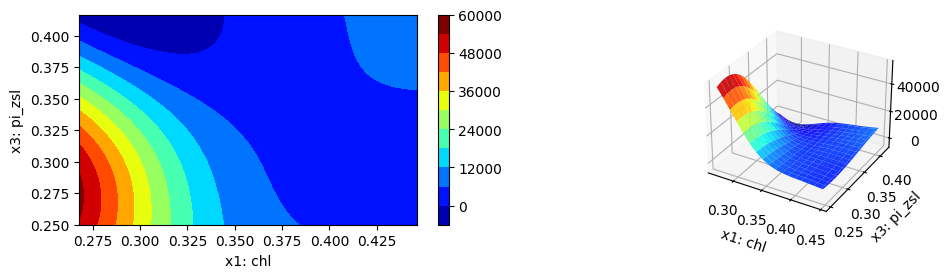

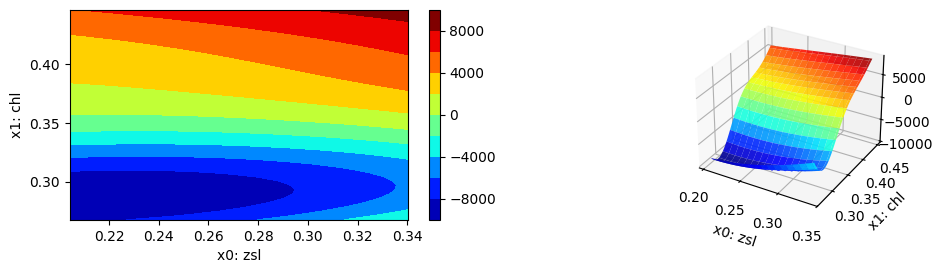

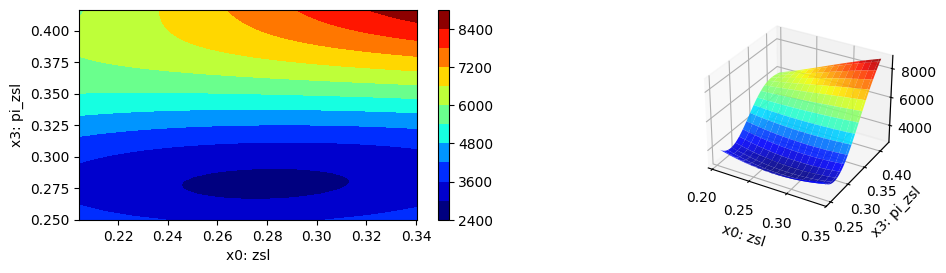

Seed set to 123


min y: 0.08532145647654846
zsl: 0.2616351395944949
chl: 0.40913115118764243
pi_chl: 0.4271416837394644
pi_zsl: 0.3636645646066102
cur: 4.674748583631231
spotpython tuning: 0.14798673577852298 [##--------] 15.00% 
spotpython tuning: 0.14798673577852298 [##--------] 17.50% 
spotpython tuning: 0.14798673577852298 [##--------] 20.00% 
spotpython tuning: 0.14798673577852298 [##--------] 22.50% 
spotpython tuning: 0.14798673577852298 [##--------] 25.00% 
spotpython tuning: 0.14798673577852298 [###-------] 27.50% 
spotpython tuning: 0.14798673577852298 [###-------] 30.00% 
spotpython tuning: 0.14798673577852298 [###-------] 32.50% 
spotpython tuning: 0.11548700421851588 [####------] 35.00% 
spotpython tuning: 0.11548700421851588 [####------] 37.50% 
spotpython tuning: 0.11548700421851588 [####------] 40.00% 
spotpython tuning: 0.11548700421851588 [####------] 42.50% 
spotpython tuning: 0.11548700421851588 [####------] 45.00% 
spotpython tuning: 0.11548700421851588 [#####-----] 47.50% 
spotpyt

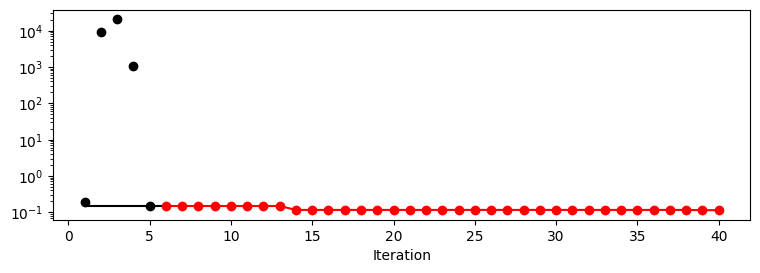

zsl:  0.001
chl:  0.001
pi_chl:  100.0
pi_zsl:  100.0
cur:  0.001


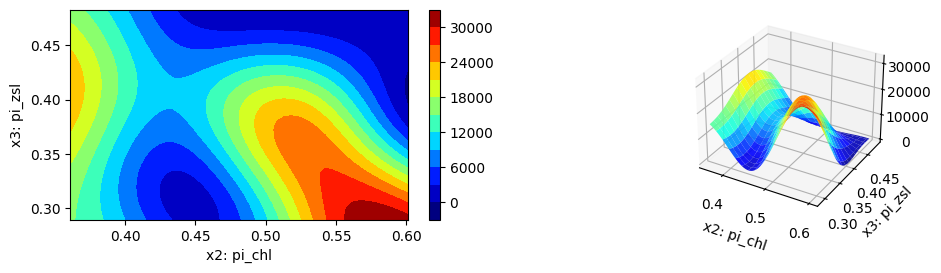

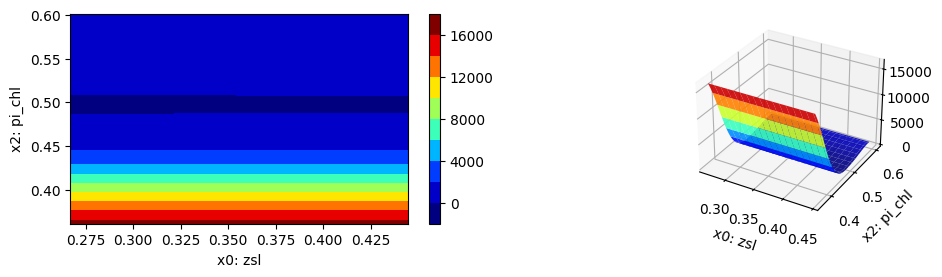

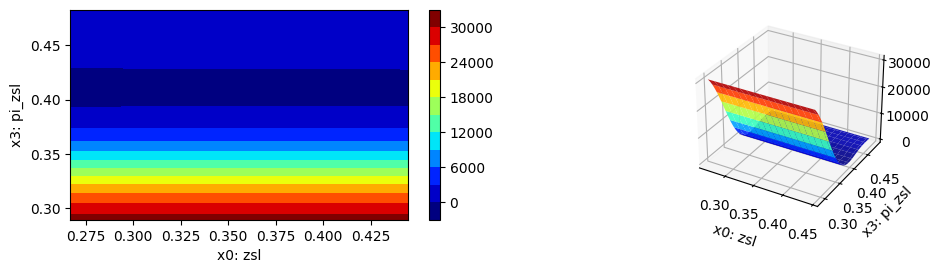

Seed set to 123


min y: 0.1135879454567943
zsl: 0.444769609418896
chl: 0.5304239054316657
pi_chl: 0.49351150521988474
pi_zsl: 0.46149753460691695
cur: 2.0
spotpython tuning: 0.2283843915637783 [##--------] 15.00% 
spotpython tuning: 0.2283843915637783 [##--------] 17.50% 
spotpython tuning: 0.2283843915637783 [##--------] 20.00% 
spotpython tuning: 0.2283843915637783 [##--------] 22.50% 
spotpython tuning: 0.2283843915637783 [##--------] 25.00% 
spotpython tuning: 0.2283843915637783 [###-------] 27.50% 
spotpython tuning: 0.2283843915637783 [###-------] 30.00% 
spotpython tuning: 0.2283843915637783 [###-------] 32.50% 
spotpython tuning: 0.2283843915637783 [####------] 35.00% 
spotpython tuning: 0.04707128536399369 [####------] 37.50% 
spotpython tuning: 0.04707128536399369 [####------] 40.00% 
spotpython tuning: 0.04707128536399369 [####------] 42.50% 
spotpython tuning: 0.04707128536399369 [####------] 45.00% 
spotpython tuning: 0.04707128536399369 [#####-----] 47.50% 
spotpython tuning: 0.0470712853

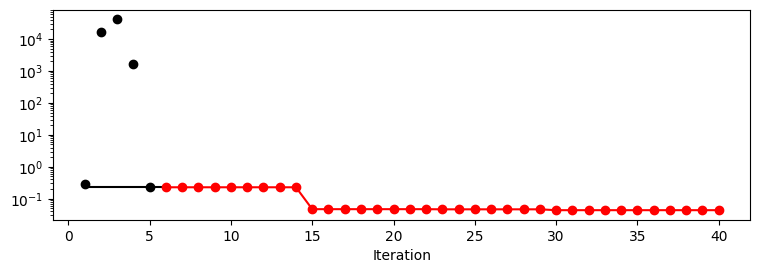

zsl:  99.99999999999999
chl:  31.77890068005538
pi_chl:  31.143445082716664
pi_zsl:  0.0011841850049362176
cur:  0.0011841850049362176


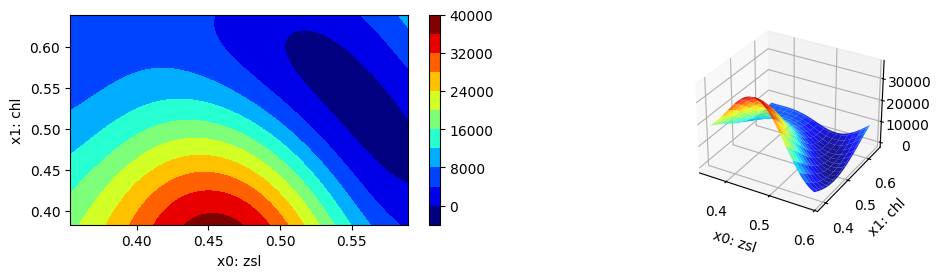

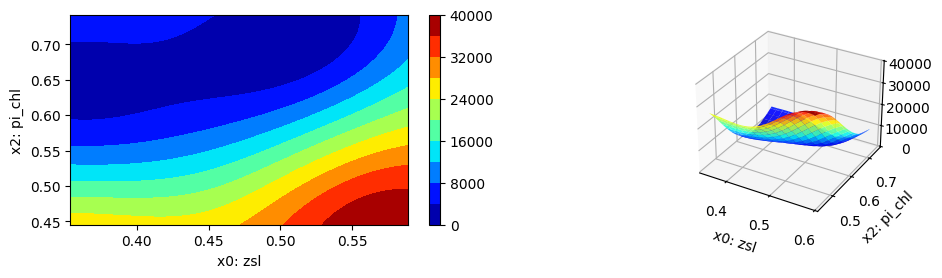

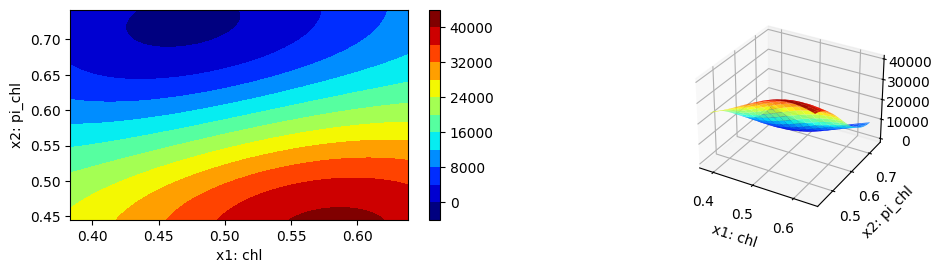

Seed set to 123


min y: 0.043772927269849646
zsl: 0.3535590427284335
chl: 0.5498341953503351
pi_chl: 0.6081764327649835
pi_zsl: 0.3711318582694611
cur: 3.9043432689698356
spotpython tuning: 0.4573256669613165 [##--------] 15.00% 
spotpython tuning: 0.4573256669613165 [##--------] 17.50% 
spotpython tuning: 0.2729361482167732 [##--------] 20.00% 
spotpython tuning: 0.2729361482167732 [##--------] 22.50% 
spotpython tuning: 0.2729361482167732 [##--------] 25.00% 
spotpython tuning: 0.2729361482167732 [###-------] 27.50% 
spotpython tuning: 0.2729361482167732 [###-------] 30.00% 
spotpython tuning: 0.2729361482167732 [###-------] 32.50% 
spotpython tuning: 0.2729361482167732 [####------] 35.00% 
spotpython tuning: 0.2729361482167732 [####------] 37.50% 
spotpython tuning: 0.2729361482167732 [####------] 40.00% 
spotpython tuning: 0.2729361482167732 [####------] 42.50% 
spotpython tuning: 0.2729361482167732 [####------] 45.00% 
spotpython tuning: 0.2729361482167732 [#####-----] 47.50% 
spotpython tuning: 0

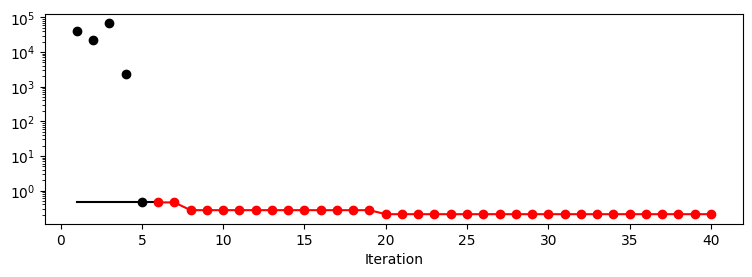

zsl:  0.001537350281908348
chl:  63.492884884259645
pi_chl:  100.0
pi_zsl:  0.0015374762590159485
cur:  0.001537350281908348


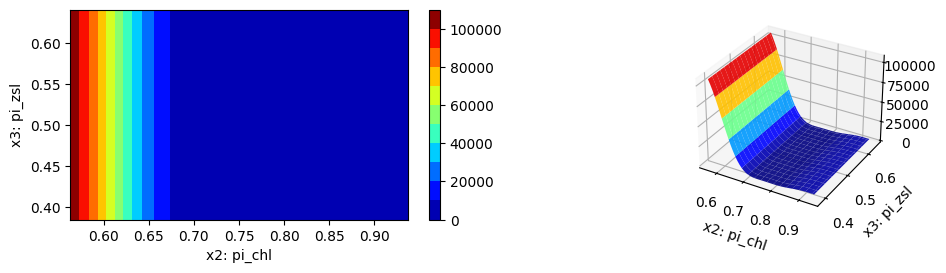

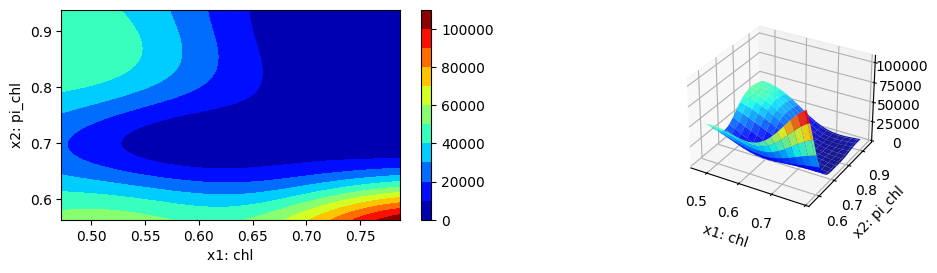

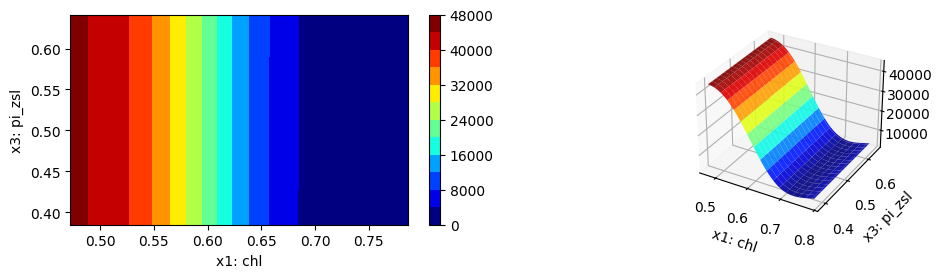

Seed set to 123


min y: 0.20913485076469343
zsl: 0.4420803524769449
chl: 0.7796957412892092
pi_chl: 0.8457568348213194
pi_zsl: 0.3847629033210237
cur: 2.0
spotpython tuning: 0.2836282015201208 [##--------] 15.00% 
spotpython tuning: 0.2836282015201208 [##--------] 17.50% 
spotpython tuning: 0.2795061296978476 [##--------] 20.00% 
spotpython tuning: 0.2795061296978476 [##--------] 22.50% 
spotpython tuning: 0.2795061296978476 [##--------] 25.00% 
spotpython tuning: 0.2795061296978476 [###-------] 27.50% 
spotpython tuning: 0.2795061296978476 [###-------] 30.00% 
spotpython tuning: 0.2795061296978476 [###-------] 32.50% 
spotpython tuning: 0.2795061296978476 [####------] 35.00% 
spotpython tuning: 0.2795061296978476 [####------] 37.50% 
spotpython tuning: 0.2795061296978476 [####------] 40.00% 
spotpython tuning: 0.2795061296978476 [####------] 42.50% 
spotpython tuning: 0.2795061296978476 [####------] 45.00% 
spotpython tuning: 0.2795061296978476 [#####-----] 47.50% 
spotpython tuning: 0.279506129697847

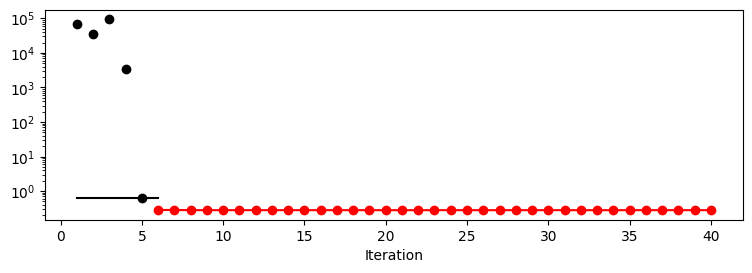

zsl:  0.002994904624932413
chl:  32.13110966494801
pi_chl:  100.0
pi_zsl:  0.0029956938164222213
cur:  0.002994887221228835


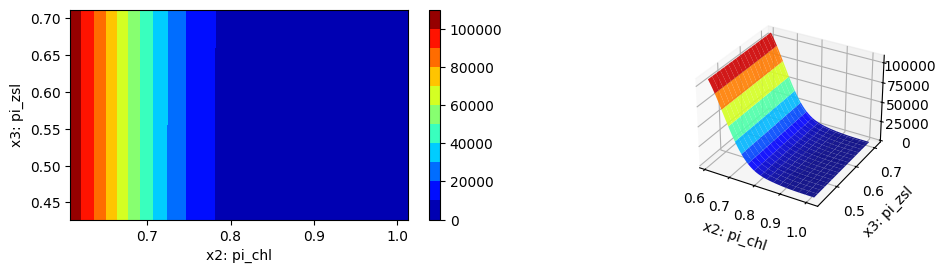

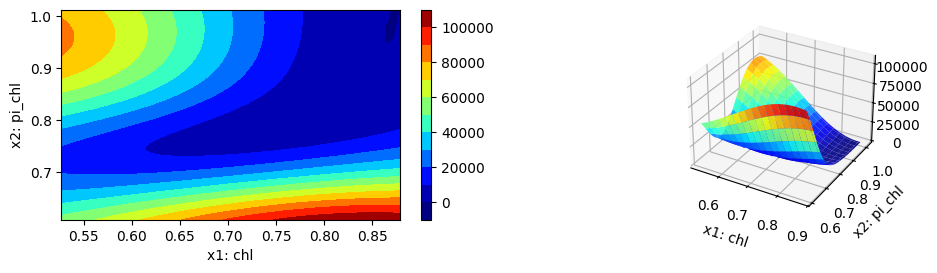

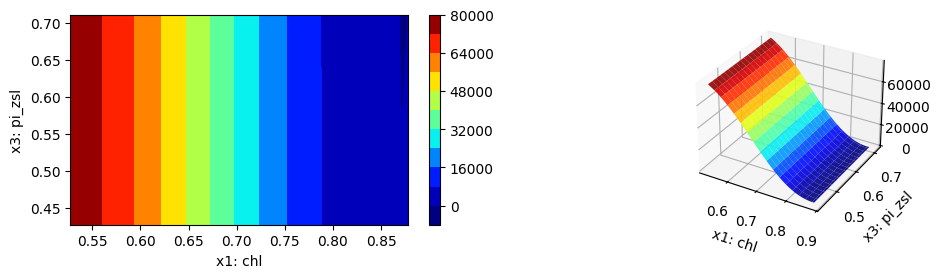

Seed set to 123


min y: 0.2795061296978476
zsl: 0.48173159042848535
chl: 0.8783596445011564
pi_chl: 0.8343308877066211
pi_zsl: 0.6310415917735185
cur: 2.0
spotpython tuning: 0.2213781696449777 [##--------] 15.00% 
spotpython tuning: 0.2213781696449777 [##--------] 17.50% 
spotpython tuning: 0.2213781696449777 [##--------] 20.00% 
spotpython tuning: 0.2213781696449777 [##--------] 22.50% 
spotpython tuning: 0.2213781696449777 [##--------] 25.00% 
spotpython tuning: 0.2213781696449777 [###-------] 27.50% 
spotpython tuning: 0.2213781696449777 [###-------] 30.00% 
spotpython tuning: 0.2213781696449777 [###-------] 32.50% 
spotpython tuning: 0.2213781696449777 [####------] 35.00% 
spotpython tuning: 0.2213781696449777 [####------] 37.50% 
spotpython tuning: 0.2213781696449777 [####------] 40.00% 
spotpython tuning: 0.2213781696449777 [####------] 42.50% 
spotpython tuning: 0.2213781696449777 [####------] 45.00% 
spotpython tuning: 0.2213781696449777 [#####-----] 47.50% 
spotpython tuning: 0.221378169644977

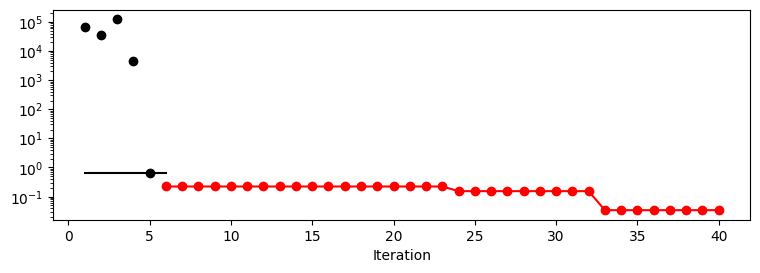

zsl:  0.0032948372386075813
chl:  41.83831760145703
pi_chl:  100.0
pi_zsl:  0.0032945434008799573
cur:  0.0033074869025268906


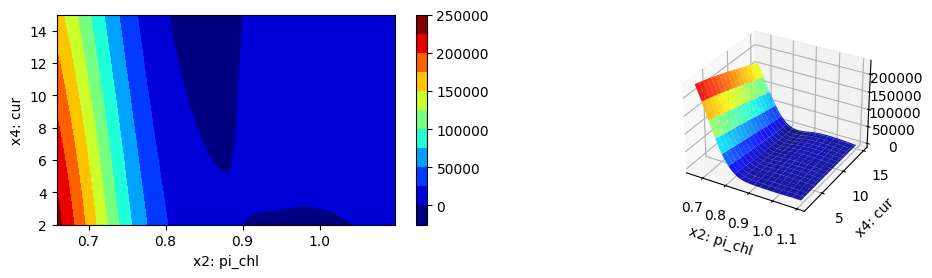

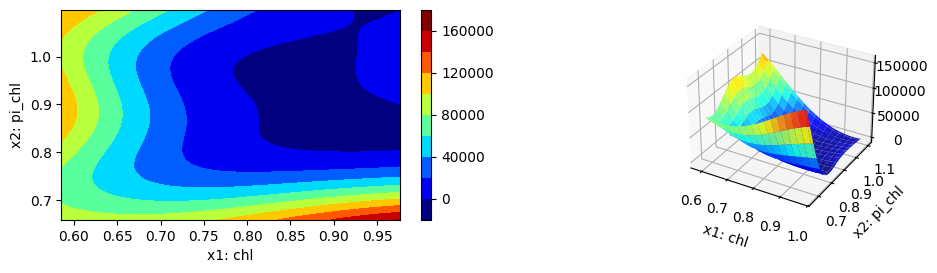

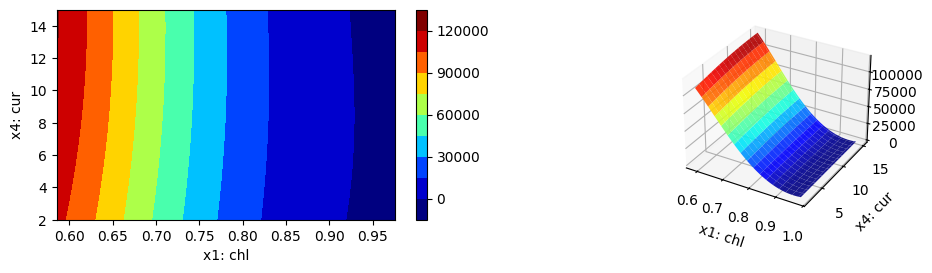

Seed set to 123


min y: 0.03395416049695328
zsl: 0.539290731505992
chl: 0.7854726586780358
pi_chl: 0.9699738718851294
pi_zsl: 0.47092215214068844
cur: 2.0
spotpython tuning: 0.7076174487350817 [##--------] 15.00% 
spotpython tuning: 0.47493491028144447 [##--------] 17.50% 
spotpython tuning: 0.47493491028144447 [##--------] 20.00% 
spotpython tuning: 0.47493491028144447 [##--------] 22.50% 
spotpython tuning: 0.47493491028144447 [##--------] 25.00% 
spotpython tuning: 0.47493491028144447 [###-------] 27.50% 
spotpython tuning: 0.47493491028144447 [###-------] 30.00% 
spotpython tuning: 0.47493491028144447 [###-------] 32.50% 
spotpython tuning: 0.47493491028144447 [####------] 35.00% 
spotpython tuning: 0.47493491028144447 [####------] 37.50% 
spotpython tuning: 0.47493491028144447 [####------] 40.00% 
spotpython tuning: 0.47493491028144447 [####------] 42.50% 
spotpython tuning: 0.47493491028144447 [####------] 45.00% 
spotpython tuning: 0.24061413277068378 [#####-----] 47.50% 
spotpython tuning: 0.24

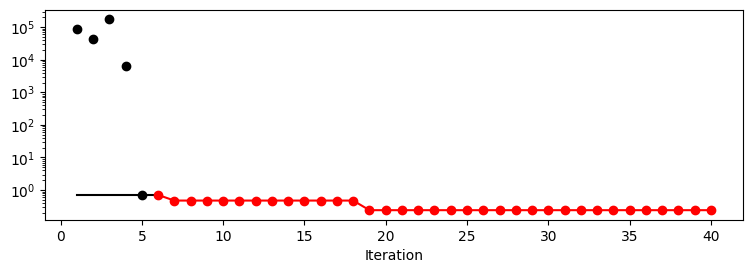

zsl:  0.00510611048713842
chl:  47.65547247557511
pi_chl:  100.0
pi_zsl:  0.00510566380382023
cur:  0.013939116812360196


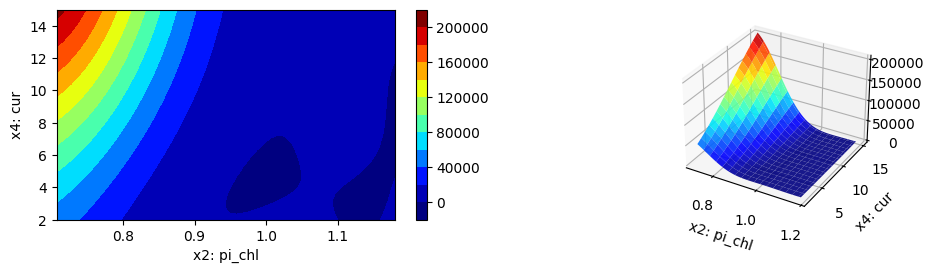

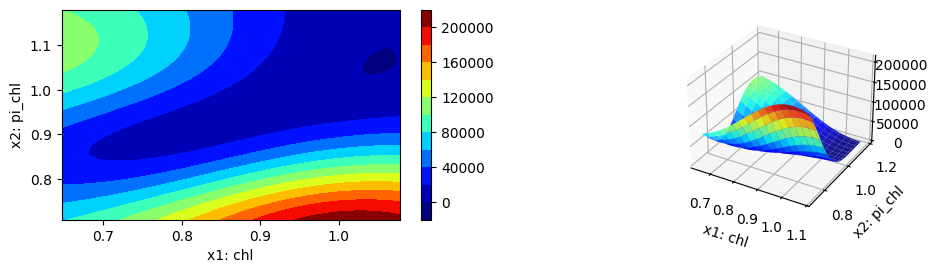

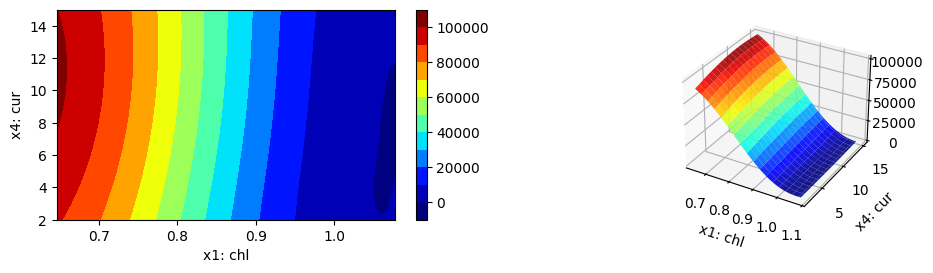

Seed set to 123


min y: 0.24061413277068378
zsl: 0.5964318783245007
chl: 1.0777820006107781
pi_chl: 0.9645927921237364
pi_zsl: 0.7767704385832264
cur: 2.0
spotpython tuning: 0.7098371059187332 [##--------] 15.00% 
spotpython tuning: 0.7098371059187332 [##--------] 17.50% 
spotpython tuning: 0.7098371059187332 [##--------] 20.00% 
spotpython tuning: 0.7098371059187332 [##--------] 22.50% 
spotpython tuning: 0.7098371059187332 [##--------] 25.00% 
spotpython tuning: 0.7098371059187332 [###-------] 27.50% 
spotpython tuning: 0.7098371059187332 [###-------] 30.00% 
spotpython tuning: 0.7098371059187332 [###-------] 32.50% 
spotpython tuning: 0.7098371059187332 [####------] 35.00% 
spotpython tuning: 0.05224974735821002 [####------] 37.50% 
spotpython tuning: 0.05224974735821002 [####------] 40.00% 
spotpython tuning: 0.05224974735821002 [####------] 42.50% 
spotpython tuning: 0.05224974735821002 [####------] 45.00% 
spotpython tuning: 0.05224974735821002 [#####-----] 47.50% 
spotpython tuning: 0.0522497473

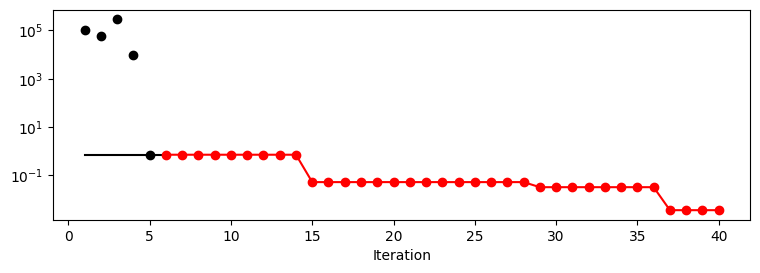

zsl:  0.004877589133076653
chl:  99.99999999999999
pi_chl:  40.11680542627737
pi_zsl:  0.004877589133076653
cur:  0.004877589133076653


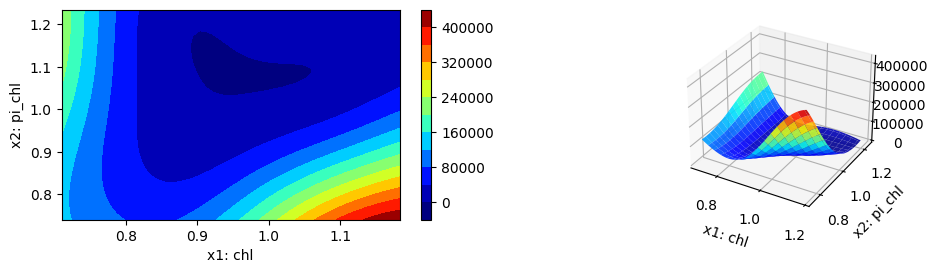

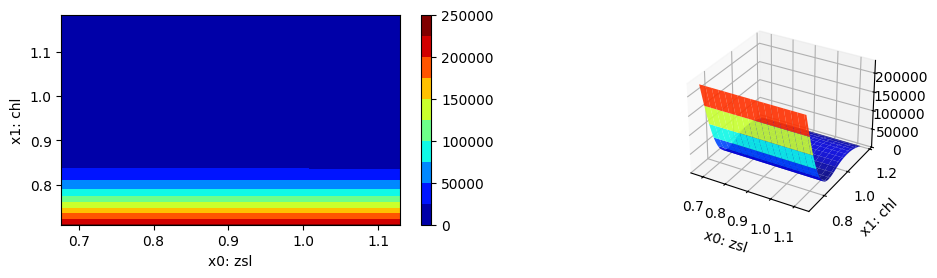

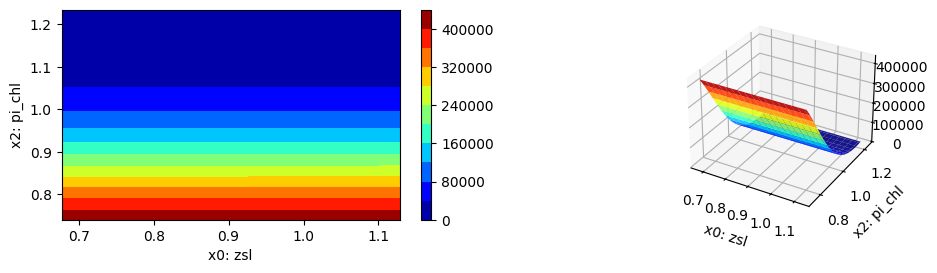

Seed set to 123


min y: 0.0036019914512276613
zsl: 0.677049846785355
chl: 1.0800559445046531
pi_chl: 1.0122719592846359
pi_zsl: 0.5899911232829241
cur: 2.0
spotpython tuning: 0.5663860603199221 [##--------] 15.00% 
spotpython tuning: 0.41166328212167175 [##--------] 17.50% 
spotpython tuning: 0.41166328212167175 [##--------] 20.00% 
spotpython tuning: 0.41166328212167175 [##--------] 22.50% 
spotpython tuning: 0.41166328212167175 [##--------] 25.00% 
spotpython tuning: 0.41166328212167175 [###-------] 27.50% 
spotpython tuning: 0.33292671024506465 [###-------] 30.00% 
spotpython tuning: 0.33292671024506465 [###-------] 32.50% 
spotpython tuning: 0.3039797310615032 [####------] 35.00% 
spotpython tuning: 0.3039797310615032 [####------] 37.50% 
spotpython tuning: 0.3039797310615032 [####------] 40.00% 
spotpython tuning: 0.3039797310615032 [####------] 42.50% 
spotpython tuning: 0.3039797310615032 [####------] 45.00% 
spotpython tuning: 0.3039797310615032 [#####-----] 47.50% 
spotpython tuning: 0.3039797

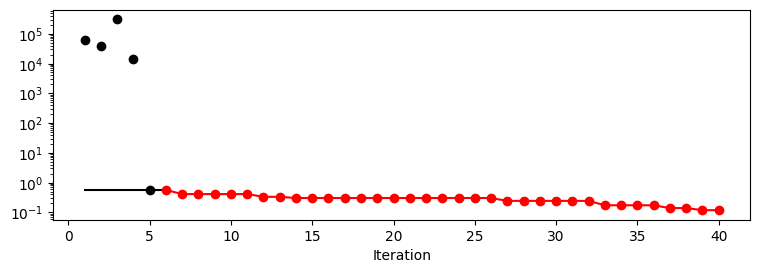

zsl:  7.7395540451353595
chl:  22.420153004359573
pi_chl:  100.0
pi_zsl:  0.113361743826349
cur:  0.0035012755986120574


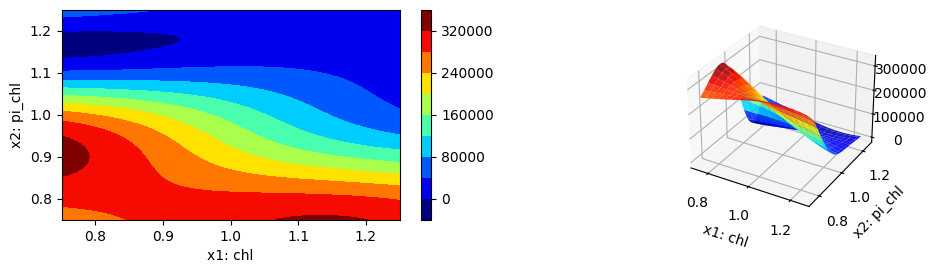

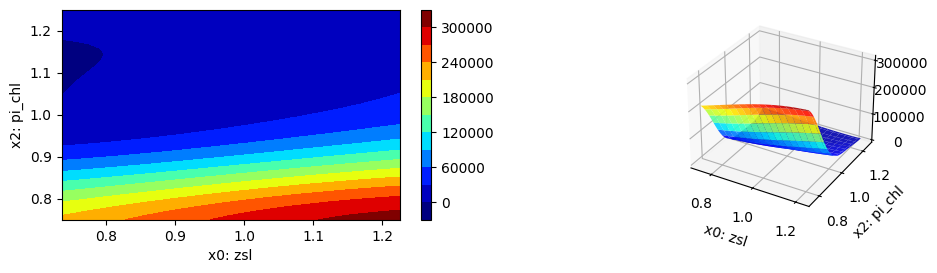

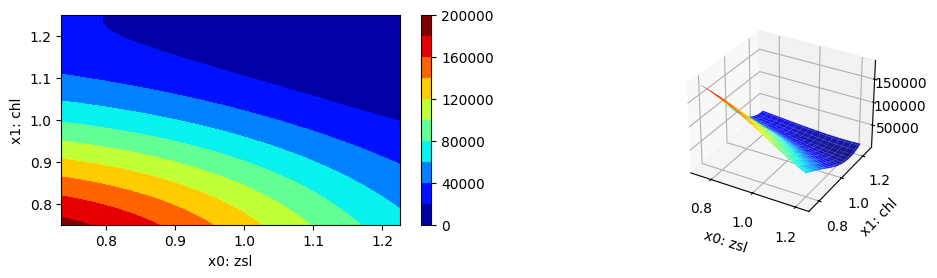

min y: 0.11853482096421304
zsl: 0.7787929446555398
chl: 1.0299026706073853
pi_chl: 1.0809288474509264
pi_zsl: 1.030904601231383
cur: 15.0


In [ ]:
test_results = execute_optimization(data_opt_pairs, fun_evals = 40, init_size = 5, x0 = None, plot_graphs = False)

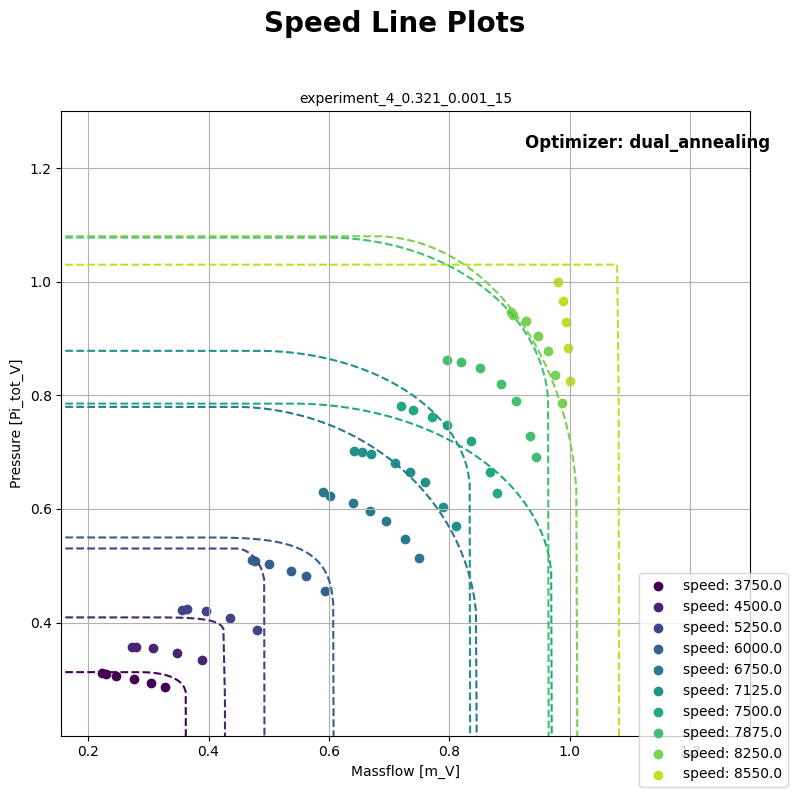

In [ ]:
plot_sld(test_results, nrows = 1, ncols = 1, figsize = (8, 8))

# plt.savefig('SpeedLinePlot-All-Optimizers-Spot', dpi = 200)

In [49]:
for result in test_results:
    print(f"Experiment Data: {result['experiment_data']}")
    print(f"Optimizer: {result['optimizer']}")
    print(f"Error:\n {result['df_err']}")
    print(f"Pressure:\n {result['df_pi']}")
    print(f"Mass Flow:\n {result['df_m']}")
    print(f"Overall Normalized RMSE for Pi: {result['overall_norm_rmse_Pi']}")
    print(f"Overall Normalized RMSE for m: {result['overall_norm_rmse_m']}")
    print("\n")

Experiment Data: experiment_4_0.321_0.001_15
Optimizer: dual_annealing
Error:
 {'3750.0': {'error_Pi_tot_V': 0.00016414519146624735, 'error_m_V': 0.005556061918407029}, '4500.0': {'error_Pi_tot_V': 0.0035083405698157952, 'error_m_V': 0.013555950725493895}, '5250.0': {'error_Pi_tot_V': 0.01296228319479933, 'error_m_V': 0.009755305896559534}, '6000.0': {'error_Pi_tot_V': 0.0015846303028748674, 'error_m_V': 0.005710857575433406}, '6750.0': {'error_Pi_tot_V': 0.014432601493361412, 'error_m_V': 0.015443805758737647}, '7125.0': {'error_Pi_tot_V': 0.020808049581495656, 'error_m_V': 0.014130216630735293}, '7500.0': {'error_Pi_tot_V': 0.0006326152639617416, 'error_m_V': 0.00421797909274587}, '7875.0': {'error_Pi_tot_V': 0.025560045821934933, 'error_m_V': 0.008813401716734181}, '8250.0': {'error_Pi_tot_V': 0.0004209602419638775, 'error_m_V': 9.360996535435986e-05}, '8550.0': {'error_Pi_tot_V': 0.015682769479460842, 'error_m_V': 0.008024194713381767}}
Pressure:
        mean      s.d.    median   

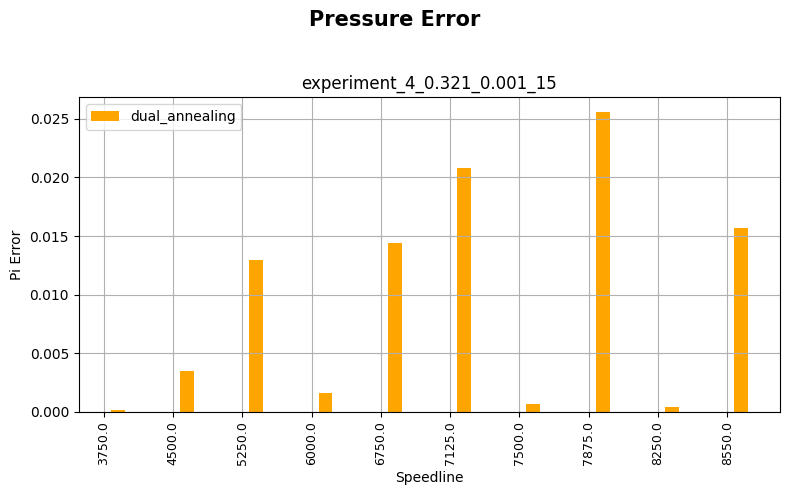

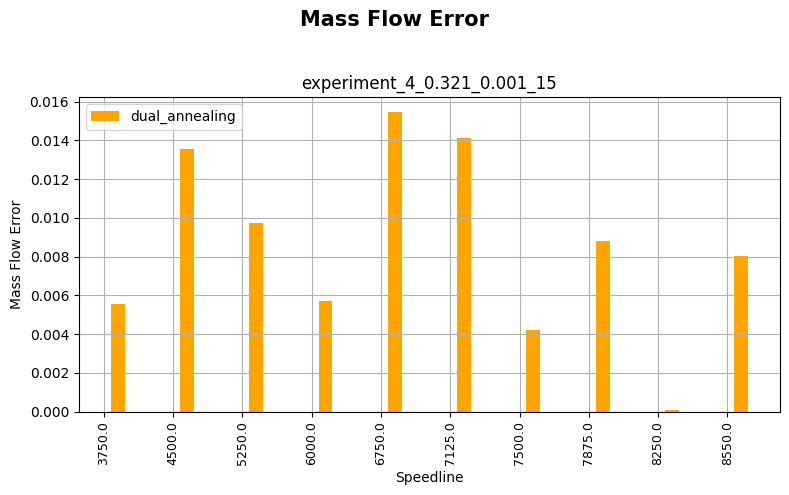

In [50]:
# Sort the list according to the datasets for plotting the graphs
exp_sorted_results = sorted(test_results, key = itemgetter('experiment_data'))

plot_eval(exp_sorted_results, 
          value = 'error_Pi_tot_V', 
          ylabel = 'Pi Error', 
          plot_title = 'Pressure Error',
          nrows = 1,
          ncols = 1,
          figsize = (8, 5))
plot_eval(exp_sorted_results, 
          value = 'error_m_V', 
          ylabel = 'Mass Flow Error', 
          plot_title = 'Mass Flow Error',
          nrows = 1,
          ncols = 1,
          figsize = (8, 5))

### Direct

In [ ]:
# Define the datasets and optimizers
exp_data_list = [
    # "experiment_4_0.321_0.1_15",
    # "experiment_4_0.321_0.01_15",
    "experiment_4_0.321_0.001_15"
    ]

opt_method_list = [
    # differential_evolution,
    # dual_annealing,
    direct
    ]

# Get the Cartesian product of the lists
data_opt_pairs = product(exp_data_list, opt_method_list)

In [ ]:
test_results = execute_optimization(data_opt_pairs, fun_evals = 40, init_size = 5, x0 = None, plot_graphs = False)

In [ ]:
plot_sld(test_results, nrows = 1, ncols = 1, figsize = (8, 8))

In [ ]:
for result in test_results:
    print(f"Experiment Data: {result['experiment_data']}")
    print(f"Optimizer: {result['optimizer']}")
    print(f"Error:\n {result['df_err']}")
    print(f"Pressure:\n {result['df_pi']}")
    print(f"Mass Flow:\n {result['df_m']}")
    print(f"Overall Normalized RMSE for Pi: {result['overall_norm_rmse_Pi']}")
    print(f"Overall Normalized RMSE for m: {result['overall_norm_rmse_m']}")
    print("\n")

In [ ]:
# Sort the list according to the datasets for plotting the graphs
exp_sorted_results = sorted(test_results, key = itemgetter('experiment_data'))

plot_eval(exp_sorted_results, 
          value = 'error_Pi_tot_V', 
          ylabel = 'Pi Error', 
          plot_title = 'Pressure Error',
          nrows = 1,
          ncols = 1,
          figsize = (8, 5))
plot_eval(exp_sorted_results, 
          value = 'error_m_V', 
          ylabel = 'Mass Flow Error', 
          plot_title = 'Mass Flow Error',
          nrows = 1,
          ncols = 1,
          figsize = (8, 5))

### Differential Evolution

In [ ]:
# Define the datasets and optimizers
exp_data_list = [
    # "experiment_4_0.321_0.1_15",
    # "experiment_4_0.321_0.01_15",
    "experiment_4_0.321_0.001_15"
    ]

opt_method_list = [
    differential_evolution,
    # dual_annealing,
    # direct
    ]

# Get the Cartesian product of the lists
data_opt_pairs = product(exp_data_list, opt_method_list)

In [ ]:
test_results = execute_optimization(data_opt_pairs, fun_evals = 40, init_size = 5, x0 = None, plot_graphs = False)

In [ ]:
plot_sld(test_results, nrows = 1, ncols = 1, figsize = (8, 8))

In [ ]:
for result in test_results:
    print(f"Experiment Data: {result['experiment_data']}")
    print(f"Optimizer: {result['optimizer']}")
    print(f"Error:\n {result['df_err']}")
    print(f"Pressure:\n {result['df_pi']}")
    print(f"Mass Flow:\n {result['df_m']}")
    print(f"Overall Normalized RMSE for Pi: {result['overall_norm_rmse_Pi']}")
    print(f"Overall Normalized RMSE for m: {result['overall_norm_rmse_m']}")
    print("\n")

In [ ]:
# Sort the list according to the datasets for plotting the graphs
exp_sorted_results = sorted(test_results, key = itemgetter('experiment_data'))

plot_eval(exp_sorted_results, 
          value = 'error_Pi_tot_V', 
          ylabel = 'Pi Error', 
          plot_title = 'Pressure Error',
          nrows = 1,
          ncols = 1,
          figsize = (8, 5))
plot_eval(exp_sorted_results, 
          value = 'error_m_V', 
          ylabel = 'Mass Flow Error', 
          plot_title = 'Mass Flow Error',
          nrows = 1,
          ncols = 1,
          figsize = (8, 5))

## With Starting Points

Experimentation is done only on Differential Evolution.

The Parameters:
- `fun_evals`: 25
- `init_size`: 3

In [22]:
# Define the datasets and optimizers
exp_data_list = [
    "experiment_4_0.321_0.1_15"
    # "experiment_4_0.321_0.01_15",
    # "experiment_4_0.321_0.001_15"
    ]

opt_method_list = [
    differential_evolution
    # dual_annealing,
    # direct
    ]

# Get the Cartesian product of the lists
data_opt_pairs = product(exp_data_list, opt_method_list)

x_values = pd.read_csv('data/x_values.csv')

def parse_array(s):
    return np.array(s.strip('[]').split(), dtype = float)

x_val = x_values['experiment_4_0.321_0.1_15'].apply(parse_array)
x_val = np.stack(x_val.values)
print(x_val)

[[0.16399884 0.33033349 0.33518722 0.19375154 2.        ]
 [0.19341909 0.3720557  0.40497521 0.23617771 2.        ]
 [0.26397909 0.4522661  0.5042925  0.2833293  2.        ]
 [0.34292417 0.52284502 0.6441302  0.32898537 2.        ]
 [0.43509552 0.66353935 0.77081687 0.39092151 2.        ]
 [0.48451794 0.73659563 0.83115631 0.42317383 2.        ]
 [0.53289429 0.80647518 0.87845626 0.59054741 2.        ]
 [0.58325931 0.86843954 0.95068807 0.62666567 2.30614047]
 [0.66786371 0.99457007 1.0000856  0.77547917 2.        ]
 [0.73156228 1.19286926 0.99725508 0.78680213 2.        ]]


Seed set to 123


Using differential_evolution optimizer on experiment_4_0.321_0.1_15 data.

spotpython tuning: 0.0057652884040632416 [######----] 56.00% 
spotpython tuning: 0.0057652884040632416 [######----] 60.00% 
spotpython tuning: 0.0057652884040632416 [######----] 64.00% 
spotpython tuning: 0.0057652884040632416 [#######---] 68.00% 
spotpython tuning: 0.0057652884040632416 [#######---] 72.00% 
spotpython tuning: 0.0057652884040632416 [########--] 76.00% 
spotpython tuning: 0.0057652884040632416 [########--] 80.00% 
spotpython tuning: 0.0057652884040632416 [########--] 84.00% 
spotpython tuning: 0.0057652884040632416 [#########-] 88.00% 
spotpython tuning: 0.0057652884040632416 [#########-] 92.00% 
spotpython tuning: 0.0057652884040632416 [##########] 96.00% 
spotpython tuning: 0.0057652884040632416 [##########] 100.00% Done...



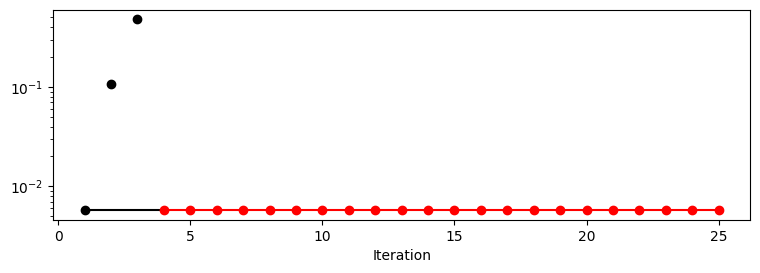

zsl:  0.0018586583578052726
chl:  0.002234026561668188
pi_chl:  100.0
pi_zsl:  0.006483671650140863
cur:  0.19997174304179


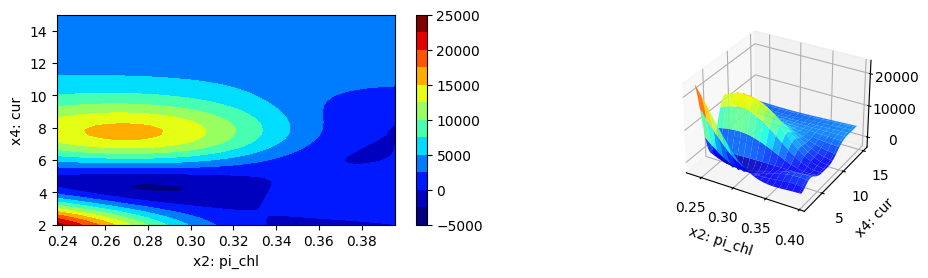

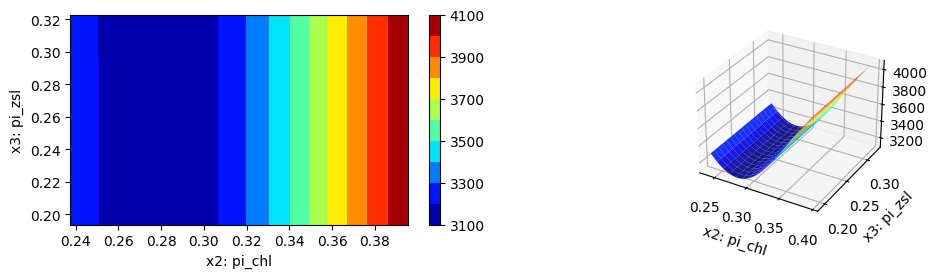

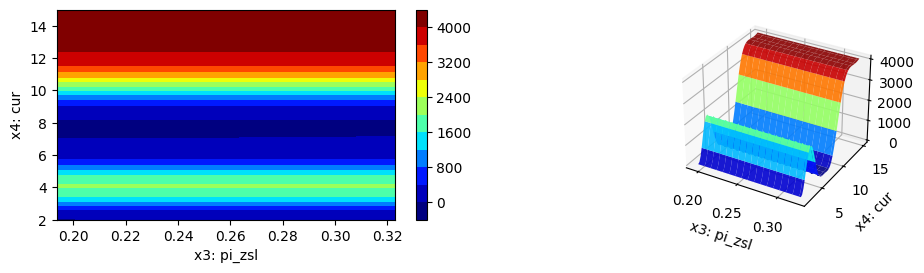

Seed set to 123


min y: 0.0057652884040632416
zsl: 0.16399884
chl: 0.33033349
pi_chl: 0.33518722
pi_zsl: 0.19375154
cur: 2.0
spotpython tuning: 0.008642738239012597 [######----] 56.00% 
spotpython tuning: 0.008642738239012597 [######----] 60.00% 
spotpython tuning: 0.008642738239012597 [######----] 64.00% 
spotpython tuning: 0.008642738239012597 [#######---] 68.00% 
spotpython tuning: 0.008642738239012597 [#######---] 72.00% 
spotpython tuning: 0.008642738239012597 [########--] 76.00% 
spotpython tuning: 0.008642738239012597 [########--] 80.00% 
spotpython tuning: 0.008642738239012597 [########--] 84.00% 
spotpython tuning: 0.008642738239012597 [#########-] 88.00% 
spotpython tuning: 0.008642738239012597 [#########-] 92.00% 
spotpython tuning: 0.008642738239012597 [##########] 96.00% 
spotpython tuning: 0.008642738239012597 [##########] 100.00% Done...



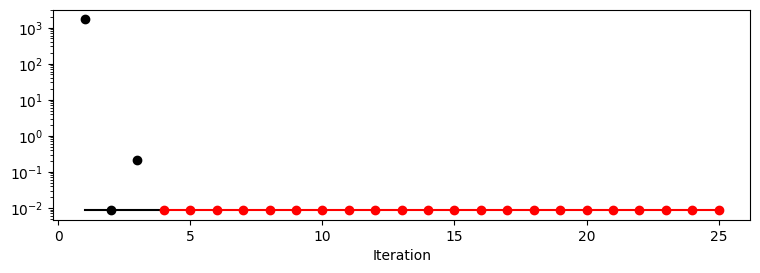

zsl:  0.7988510925265233
chl:  99.99999999999999
pi_chl:  28.234422147198497
pi_zsl:  0.06865431862060395
cur:  0.0025092374961090246


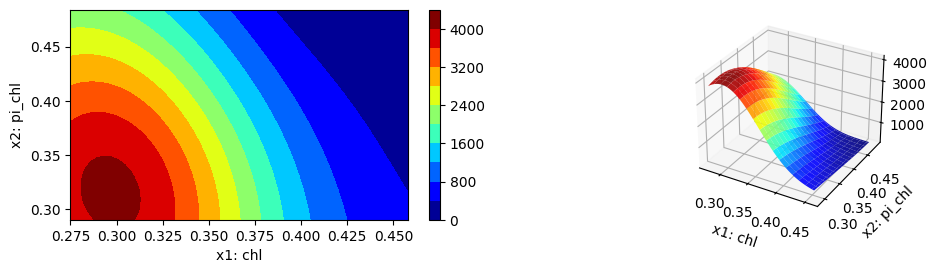

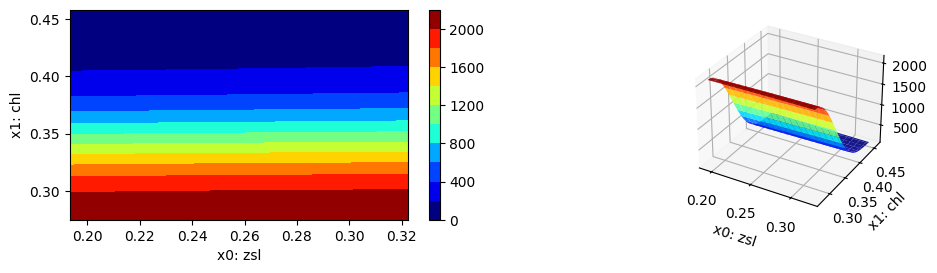

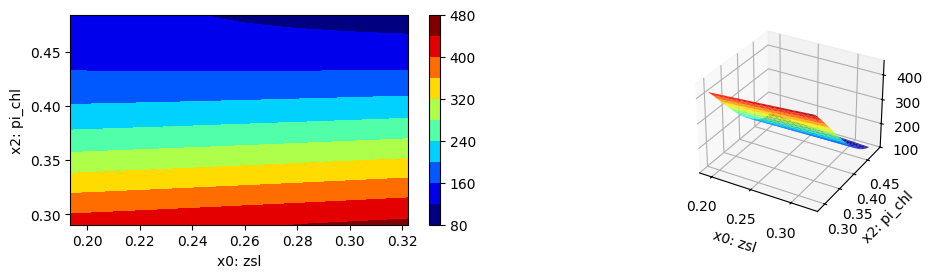

Seed set to 123


min y: 0.008642738239012597
zsl: 0.19341909
chl: 0.3720557
pi_chl: 0.40497521
pi_zsl: 0.23617771
cur: 2.0
spotpython tuning: 0.010088110998091766 [######----] 56.00% 
spotpython tuning: 0.010088110998091766 [######----] 60.00% 
spotpython tuning: 0.010088110998091766 [######----] 64.00% 
spotpython tuning: 0.010088110998091766 [#######---] 68.00% 
spotpython tuning: 0.010088110998091766 [#######---] 72.00% 
spotpython tuning: 0.010088110998091766 [########--] 76.00% 
spotpython tuning: 0.010088110998091766 [########--] 80.00% 
spotpython tuning: 0.010088110998091766 [########--] 84.00% 
spotpython tuning: 0.010088110998091766 [#########-] 88.00% 
spotpython tuning: 0.010088110998091766 [#########-] 92.00% 
spotpython tuning: 0.010088110998091766 [##########] 96.00% 
spotpython tuning: 0.010088110998091766 [##########] 100.00% Done...



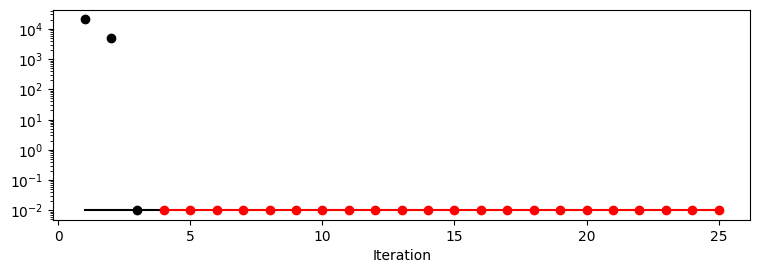

zsl:  0.00608095261097325
chl:  100.0
pi_chl:  0.0035935172341044082
pi_zsl:  0.004719586826283199
cur:  0.001


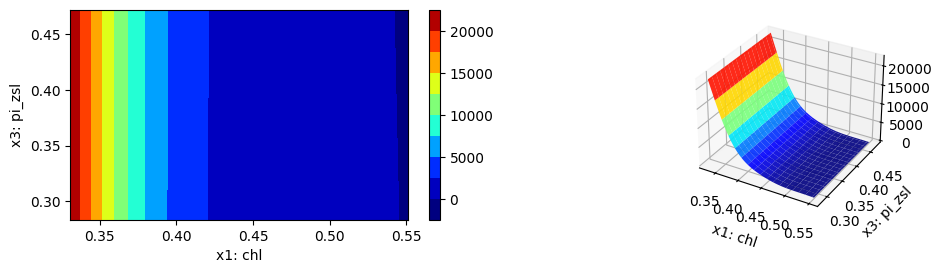

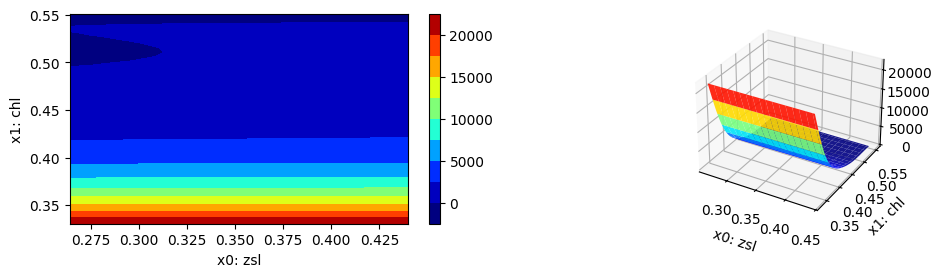

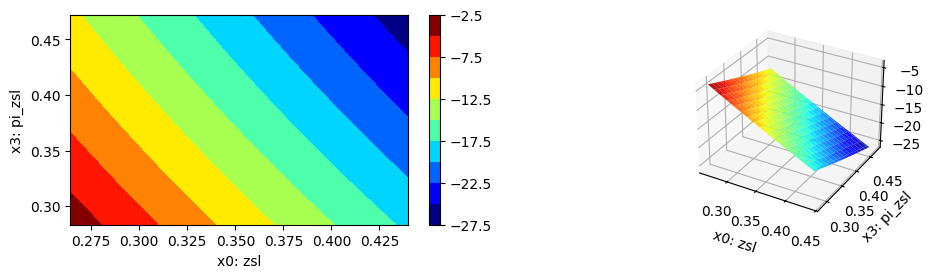

Seed set to 123


min y: 0.010088110998091766
zsl: 0.26397909
chl: 0.4522661
pi_chl: 0.5042925
pi_zsl: 0.2833293
cur: 2.0
spotpython tuning: 0.005611892131418239 [######----] 56.00% 
spotpython tuning: 0.005611892131418239 [######----] 60.00% 
spotpython tuning: 0.005611892131418239 [######----] 64.00% 
spotpython tuning: 0.005611892131418239 [#######---] 68.00% 
spotpython tuning: 0.005611892131418239 [#######---] 72.00% 
spotpython tuning: 0.005611892131418239 [########--] 76.00% 
spotpython tuning: 0.005611892131418239 [########--] 80.00% 
spotpython tuning: 0.005611892131418239 [########--] 84.00% 
spotpython tuning: 0.005611892131418239 [#########-] 88.00% 
spotpython tuning: 0.005611892131418239 [#########-] 92.00% 
spotpython tuning: 0.005611892131418239 [##########] 96.00% 
spotpython tuning: 0.005611892131418239 [##########] 100.00% Done...



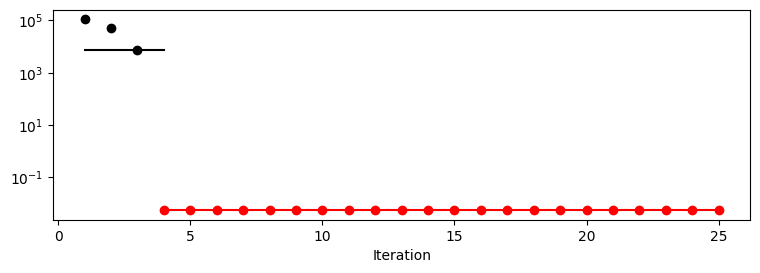

zsl:  0.001919153195179794
chl:  100.0
pi_chl:  0.8705885373484671
pi_zsl:  11.984585384471767
cur:  0.001919153195179794


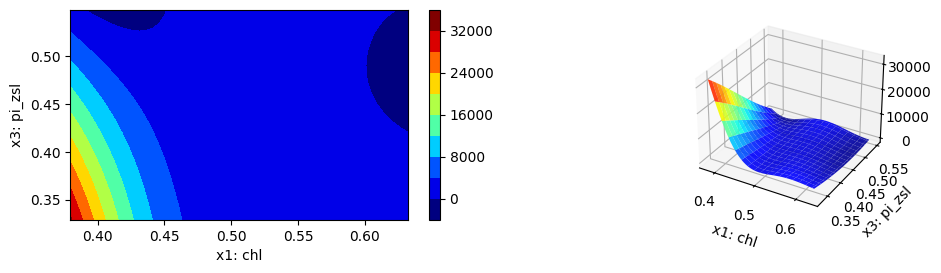

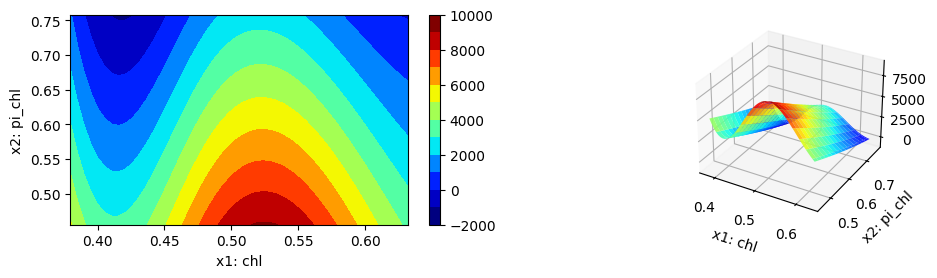

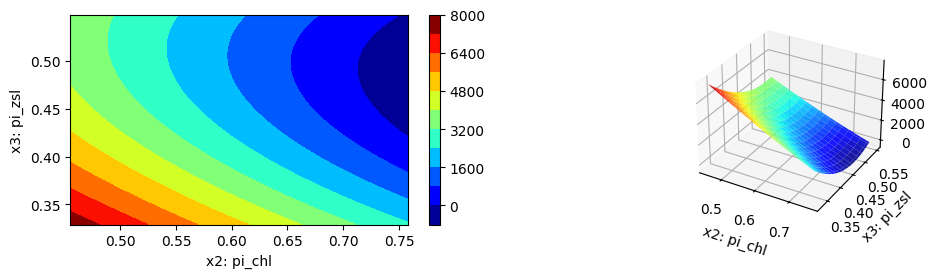

Seed set to 123


min y: 0.005611892131418239
zsl: 0.34292417
chl: 0.52284502
pi_chl: 0.6441302
pi_zsl: 0.32898537
cur: 2.0
spotpython tuning: 0.017079802807744935 [######----] 56.00% 
spotpython tuning: 0.017079802807744935 [######----] 60.00% 
spotpython tuning: 0.017079802807744935 [######----] 64.00% 
spotpython tuning: 0.017079802807744935 [#######---] 68.00% 
spotpython tuning: 0.017079802807744935 [#######---] 72.00% 
spotpython tuning: 0.017079802807744935 [########--] 76.00% 
spotpython tuning: 0.017079802807744935 [########--] 80.00% 
spotpython tuning: 0.017079802807744935 [########--] 84.00% 
spotpython tuning: 0.017079802807744935 [#########-] 88.00% 
spotpython tuning: 0.017079802807744935 [#########-] 92.00% 
spotpython tuning: 0.017079802807744935 [##########] 96.00% 
spotpython tuning: 0.017079802807744935 [##########] 100.00% Done...



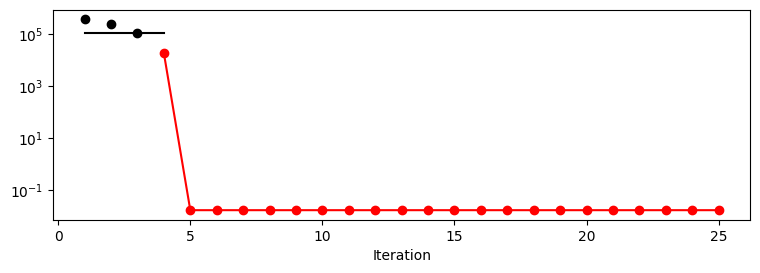

zsl:  0.003553109804717684
chl:  100.0
pi_chl:  36.20847078488411
pi_zsl:  0.003553109804717684
cur:  0.003553109804717684


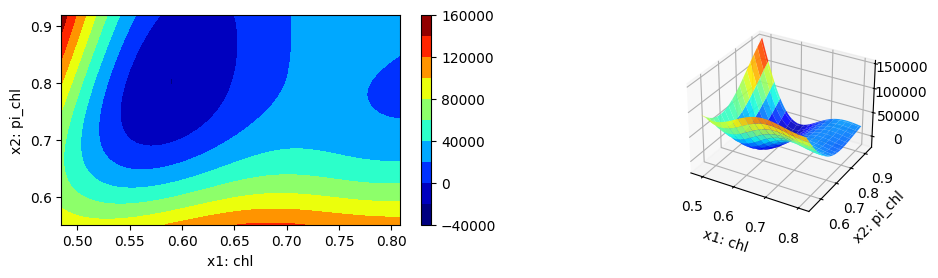

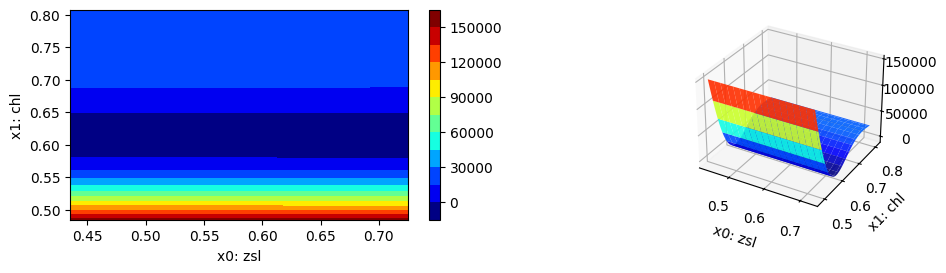

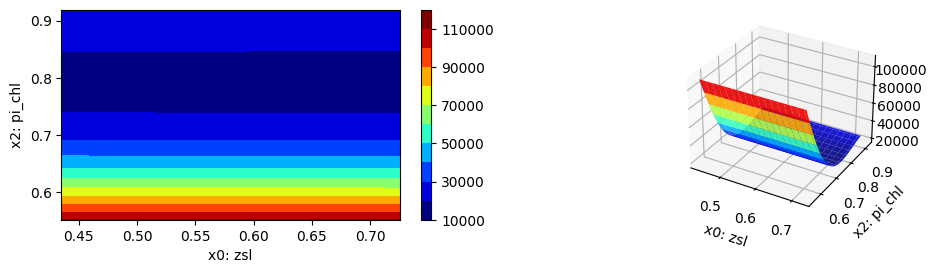

Seed set to 123


min y: 0.017079802807744935
zsl: 0.43509552
chl: 0.66353935
pi_chl: 0.77081687
pi_zsl: 0.39092151
cur: 2.0
spotpython tuning: 0.006402144087652242 [######----] 56.00% 
spotpython tuning: 0.006402144087652242 [######----] 60.00% 
spotpython tuning: 0.006402144087652242 [######----] 64.00% 
spotpython tuning: 0.006402144087652242 [#######---] 68.00% 
spotpython tuning: 0.006402144087652242 [#######---] 72.00% 
spotpython tuning: 0.006402144087652242 [########--] 76.00% 
spotpython tuning: 0.006402144087652242 [########--] 80.00% 
spotpython tuning: 0.006402144087652242 [########--] 84.00% 
spotpython tuning: 0.006402144087652242 [#########-] 88.00% 
spotpython tuning: 0.006402144087652242 [#########-] 92.00% 
spotpython tuning: 0.006402144087652242 [##########] 96.00% 
spotpython tuning: 0.006402144087652242 [##########] 100.00% Done...



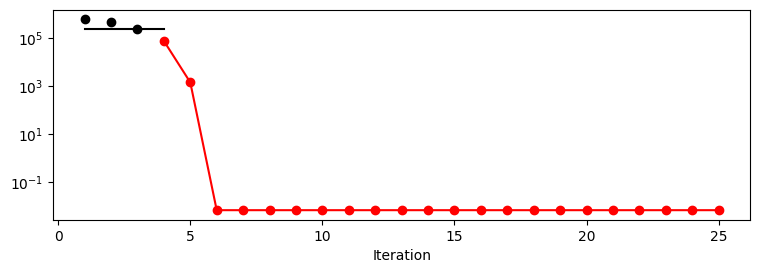

zsl:  0.0012316039524828252
chl:  15.109631325399175
pi_chl:  0.0012316039524828252
pi_zsl:  100.0
cur:  0.0012316039524828252


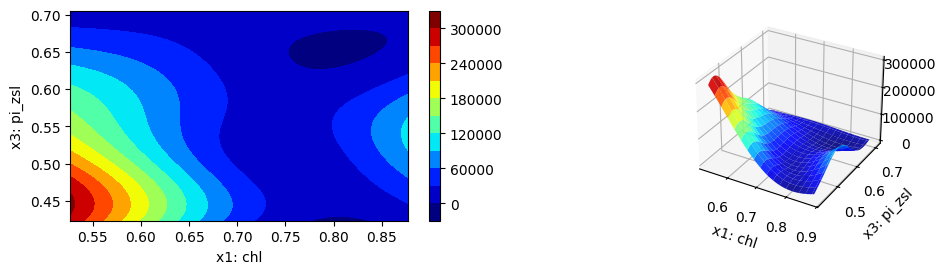

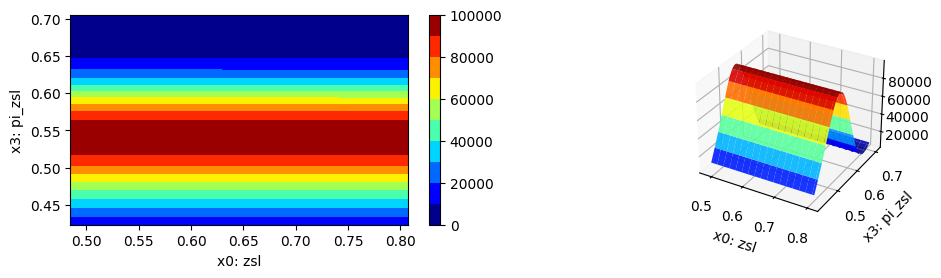

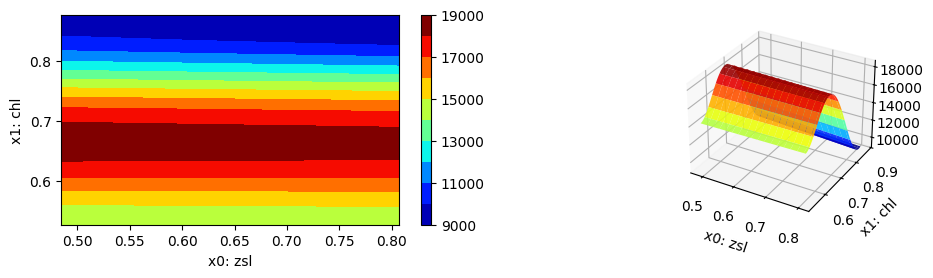

Seed set to 123


min y: 0.006402144087652242
zsl: 0.48451794
chl: 0.73659563
pi_chl: 0.83115631
pi_zsl: 0.42317383
cur: 2.0
spotpython tuning: 0.007756822618799074 [######----] 56.00% 
spotpython tuning: 0.007756822618799074 [######----] 60.00% 
spotpython tuning: 0.007756822618799074 [######----] 64.00% 
spotpython tuning: 0.007756822618799074 [#######---] 68.00% 
spotpython tuning: 0.007756822618799074 [#######---] 72.00% 
spotpython tuning: 0.007756822618799074 [########--] 76.00% 
spotpython tuning: 0.007756822618799074 [########--] 80.00% 
spotpython tuning: 0.007756822618799074 [########--] 84.00% 
spotpython tuning: 0.007756822618799074 [#########-] 88.00% 
spotpython tuning: 0.007756822618799074 [#########-] 92.00% 
spotpython tuning: 0.007756822618799074 [##########] 96.00% 
spotpython tuning: 0.007756822618799074 [##########] 100.00% Done...



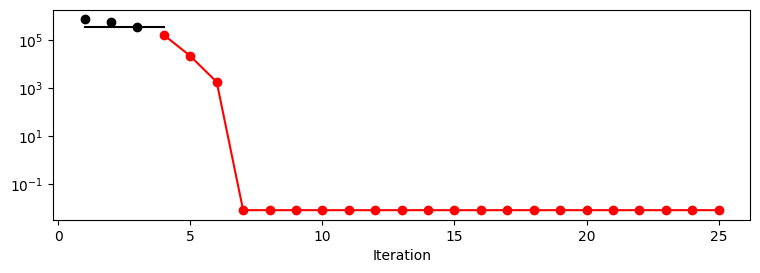

zsl:  0.005726105259795661
chl:  1.6333902358172903
pi_chl:  100.0
pi_zsl:  0.005726105259795661
cur:  0.005726105259795661


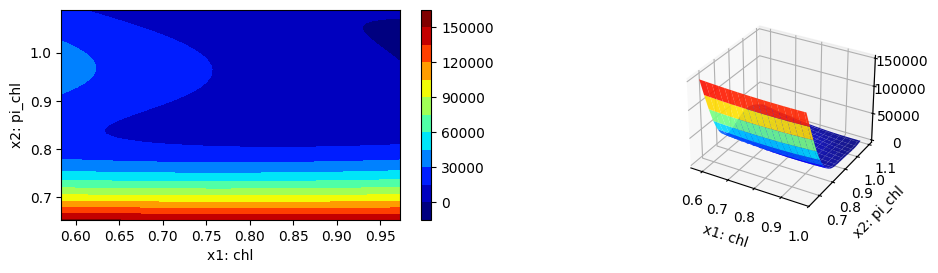

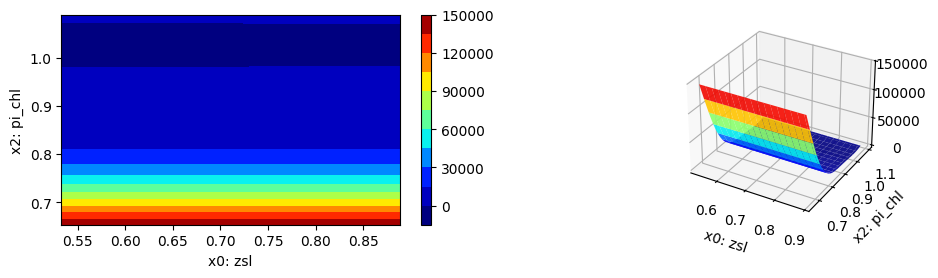

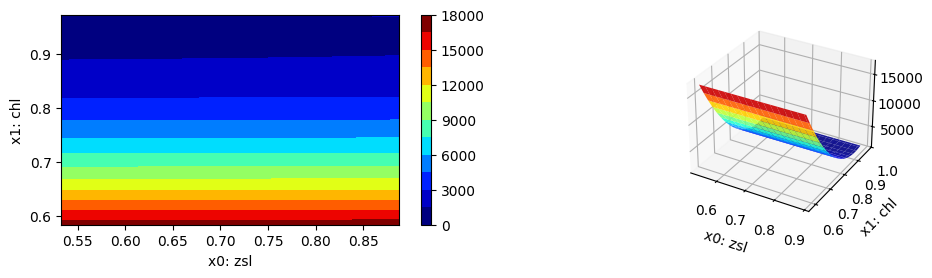

Seed set to 123


min y: 0.007756822618799074
zsl: 0.53289429
chl: 0.80647518
pi_chl: 0.87845626
pi_zsl: 0.59054741
cur: 2.0
spotpython tuning: 0.00038649767579532413 [######----] 56.00% 
spotpython tuning: 0.00038649767579532413 [######----] 60.00% 
spotpython tuning: 0.00038649767579532413 [######----] 64.00% 
spotpython tuning: 0.00038649767579532413 [#######---] 68.00% 
spotpython tuning: 0.00038649767579532413 [#######---] 72.00% 
spotpython tuning: 0.00038649767579532413 [########--] 76.00% 
spotpython tuning: 0.00038649767579532413 [########--] 80.00% 
spotpython tuning: 0.00038649767579532413 [########--] 84.00% 
spotpython tuning: 0.00038649767579532413 [#########-] 88.00% 
spotpython tuning: 0.00038649767579532413 [#########-] 92.00% 
spotpython tuning: 0.00038649767579532413 [##########] 96.00% 
spotpython tuning: 0.00038649767579532413 [##########] 100.00% Done...



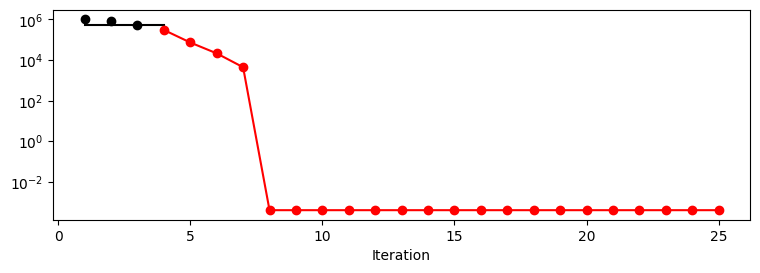

zsl:  0.03388314036652127
chl:  81.05252814501088
pi_chl:  100.0
pi_zsl:  0.1364372289510326
cur:  0.027627175732430745


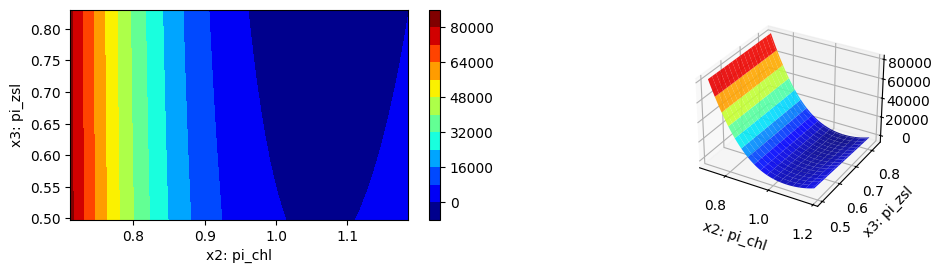

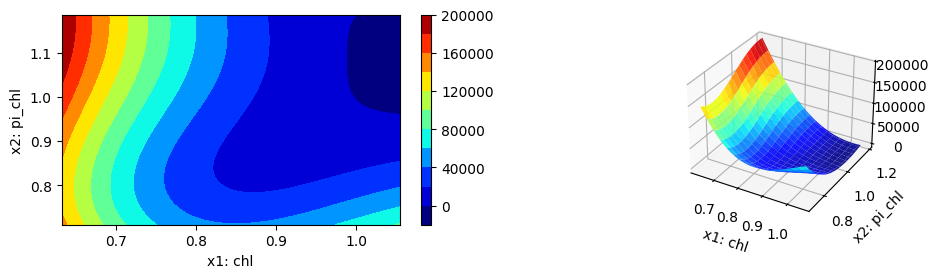

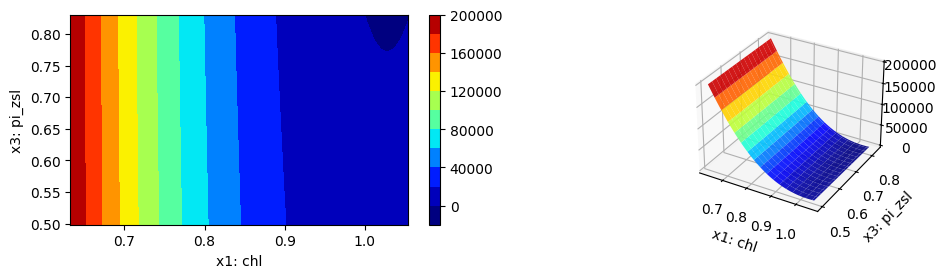

Seed set to 123


min y: 0.00038649767579532413
zsl: 0.58325931
chl: 0.86843954
pi_chl: 0.95068807
pi_zsl: 0.62666567
cur: 2.30614047
spotpython tuning: 0.0011312311346008245 [######----] 56.00% 
spotpython tuning: 0.0011312311346008245 [######----] 60.00% 
spotpython tuning: 0.0011312311346008245 [######----] 64.00% 
spotpython tuning: 0.0011312311346008245 [#######---] 68.00% 
spotpython tuning: 0.0011312311346008245 [#######---] 72.00% 
spotpython tuning: 0.0011312311346008245 [########--] 76.00% 
spotpython tuning: 0.0011312311346008245 [########--] 80.00% 
spotpython tuning: 0.0011312311346008245 [########--] 84.00% 
spotpython tuning: 0.0011312311346008245 [#########-] 88.00% 
spotpython tuning: 0.0011312311346008245 [#########-] 92.00% 
spotpython tuning: 0.0011312311346008245 [##########] 96.00% 
spotpython tuning: 0.0011312311346008245 [##########] 100.00% Done...



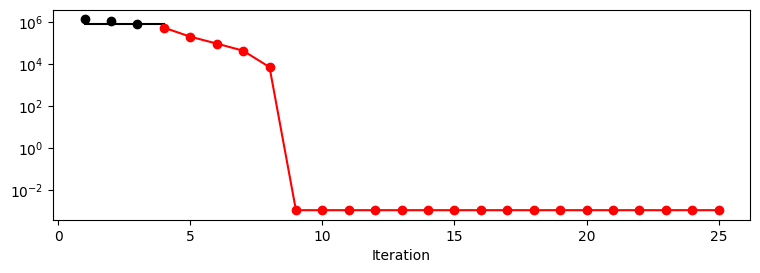

zsl:  0.007183525580159224
chl:  0.007339666401692401
pi_chl:  100.0
pi_zsl:  0.011669281400142334
cur:  0.006539558769906752


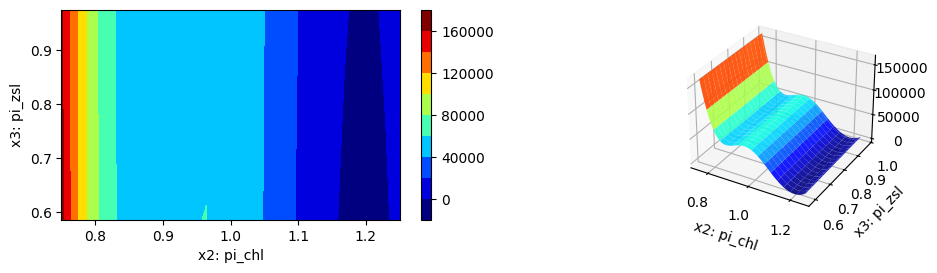

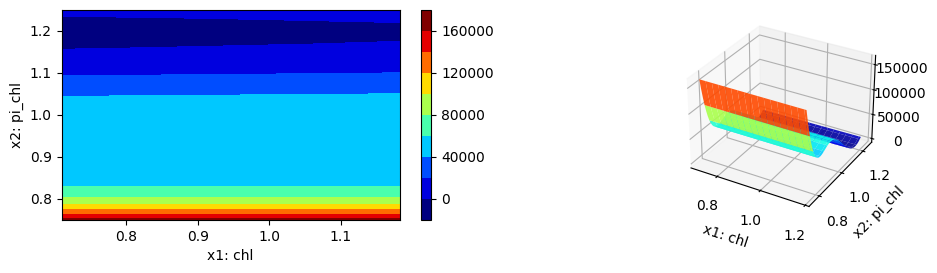

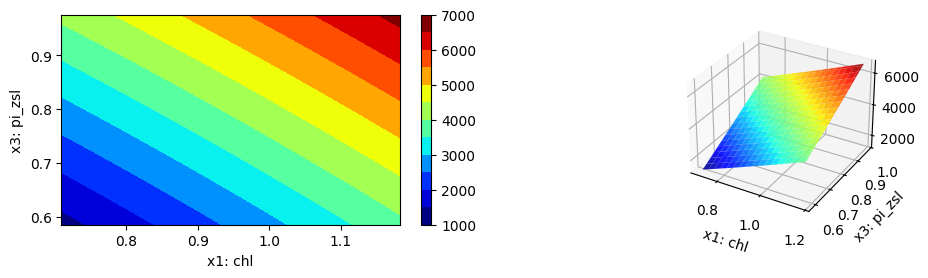

Seed set to 123


min y: 0.0011312311346008245
zsl: 0.66786371
chl: 0.99457007
pi_chl: 1.0000856
pi_zsl: 0.77547917
cur: 2.0
spotpython tuning: 0.02118979419873757 [######----] 56.00% 
spotpython tuning: 0.02118979419873757 [######----] 60.00% 
spotpython tuning: 0.02118979419873757 [######----] 64.00% 
spotpython tuning: 0.02118979419873757 [#######---] 68.00% 
spotpython tuning: 0.02118979419873757 [#######---] 72.00% 
spotpython tuning: 0.02118979419873757 [########--] 76.00% 
spotpython tuning: 0.02118979419873757 [########--] 80.00% 
spotpython tuning: 0.02118979419873757 [########--] 84.00% 
spotpython tuning: 0.02118979419873757 [#########-] 88.00% 
spotpython tuning: 0.02118979419873757 [#########-] 92.00% 
spotpython tuning: 0.02118979419873757 [##########] 96.00% 
spotpython tuning: 0.02118979419873757 [##########] 100.00% Done...



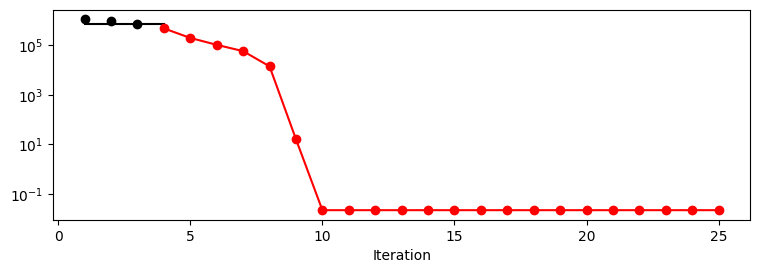

zsl:  12.057232903243888
chl:  100.0
pi_chl:  74.23979024274024
pi_zsl:  0.12474943068764903
cur:  0.022590765535170067


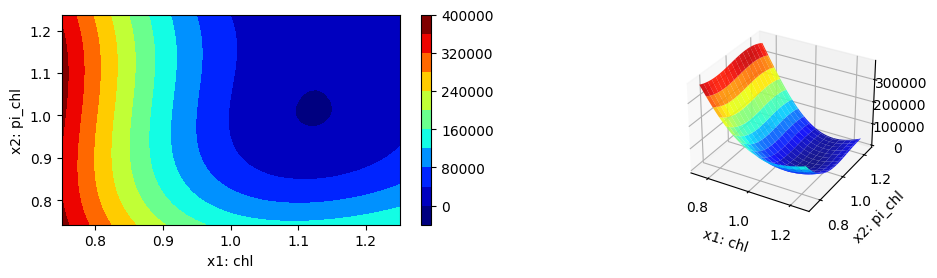

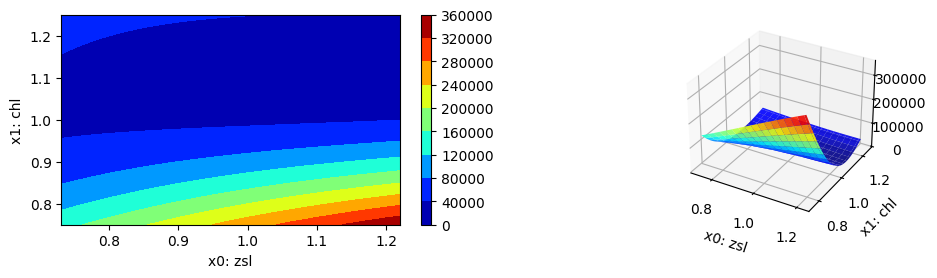

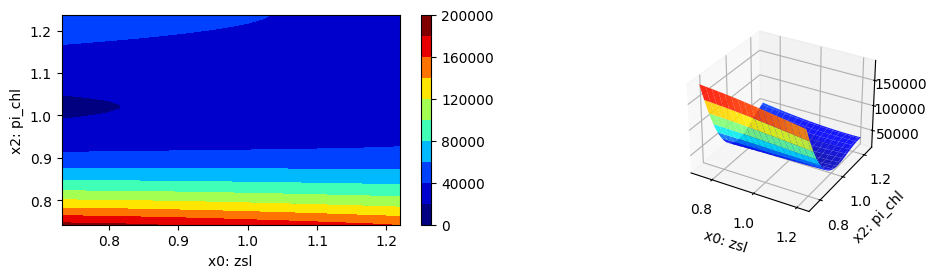

min y: 0.02118979419873757
zsl: 0.73156228
chl: 1.19286926
pi_chl: 0.99725508
pi_zsl: 0.78680213
cur: 2.0


In [23]:
test_results = execute_optimization(data_opt_pairs, x0 = x_val, fun_evals = 25, plot_graphs = True, init_size = 3)

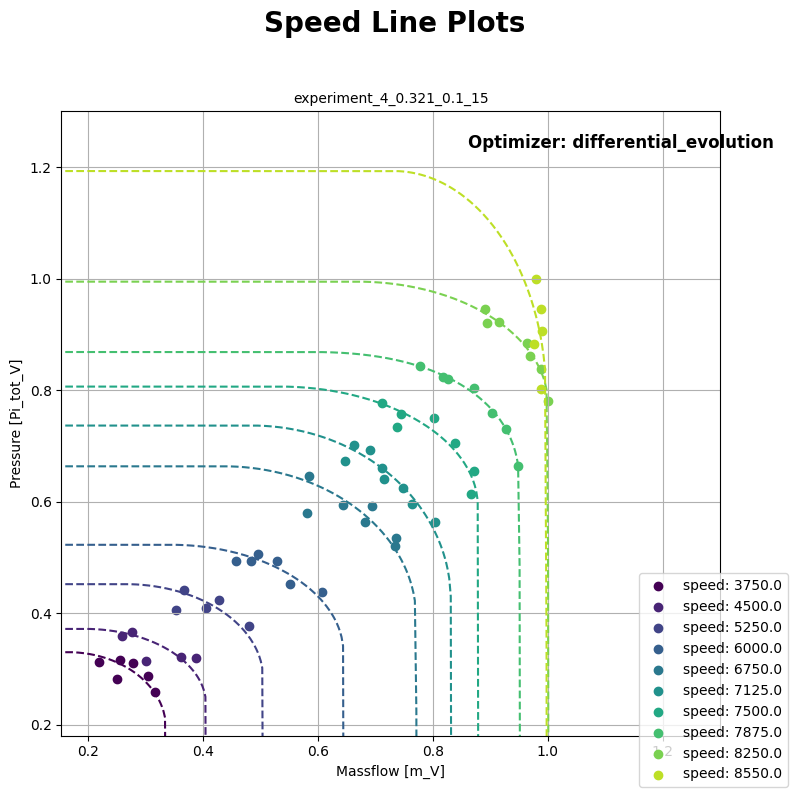

In [24]:
plot_sld(test_results, nrows = 1, ncols = 1, figsize = (8, 8))

In [25]:
for result in test_results:
    print(f"Experiment Data: {result['experiment_data']}")
    print(f"Optimizer: {result['optimizer']}")
    print(f"Error:\n {result['df_err']}")
    print(f"Pressure:\n {result['df_pi']}")
    print(f"Mass Flow:\n {result['df_m']}")
    print(f"Overall Normalized RMSE for Pi: {result['overall_norm_rmse_Pi']}")
    print(f"Overall Normalized RMSE for m: {result['overall_norm_rmse_m']}")
    print("\n")

Experiment Data: experiment_4_0.321_0.1_15
Optimizer: differential_evolution
Error:
 {'3750.0': {'error_Pi_tot_V': 0.0002591408354010011, 'error_m_V': 0.0007017405652762058}, '4500.0': {'error_Pi_tot_V': 0.0004847963829218543, 'error_m_V': 0.0012437512648806651}, '5250.0': {'error_Pi_tot_V': 0.00042240931674576216, 'error_m_V': 0.001595212882872591}, '6000.0': {'error_Pi_tot_V': 0.00016771442652301476, 'error_m_V': 0.0007676009287133585}, '6750.0': {'error_Pi_tot_V': 0.0007068888695229521, 'error_m_V': 0.0017330829601548956}, '7125.0': {'error_Pi_tot_V': 0.0002641190236926733, 'error_m_V': 0.000536148987263857}, '7500.0': {'error_Pi_tot_V': 0.0004640297622032012, 'error_m_V': 0.000644087754768095}, '7875.0': {'error_Pi_tot_V': 1.8539956645339632e-05, 'error_m_V': 3.6673997039706675e-05}, '8250.0': {'error_Pi_tot_V': 6.0938894598527606e-05, 'error_m_V': 0.00010066555320159015}, '8550.0': {'error_Pi_tot_V': 0.0040572910646594915, 'error_m_V': 0.00018066777508802252}}
Pressure:
        me

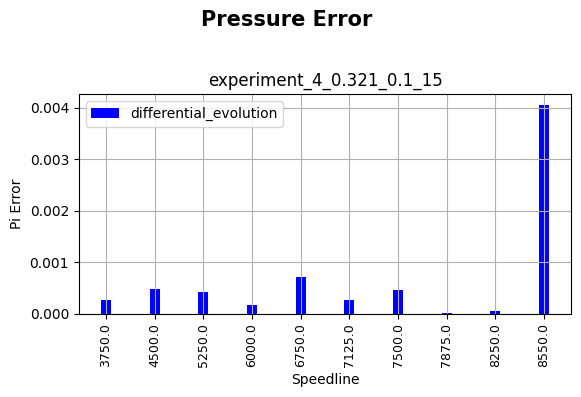

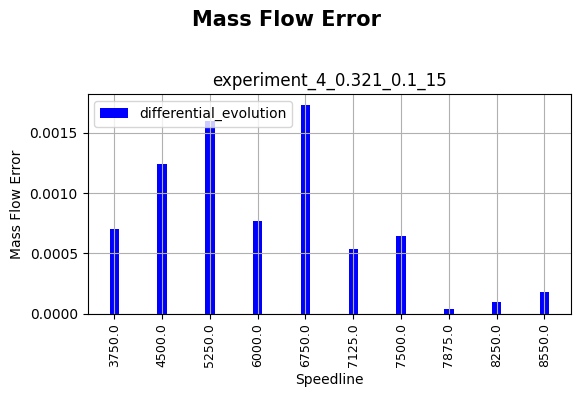

In [26]:
# Sort the list according to the datasets for plotting the graphs
exp_sorted_results = sorted(test_results, key = itemgetter('experiment_data'))

plot_eval(exp_sorted_results, 
          value = 'error_Pi_tot_V', 
          ylabel = 'Pi Error', 
          plot_title = 'Pressure Error',
          nrows = 1,
          ncols = 1,
          figsize = (6, 4))
plot_eval(exp_sorted_results, 
          value = 'error_m_V', 
          ylabel = 'Mass Flow Error', 
          plot_title = 'Mass Flow Error',
          nrows = 1,
          ncols = 1,
          figsize = (6, 4))